# <p style="text-align:center;"> Pavages aléatoires </p>

Le but de ce Notebook est de mesurer à l'aide de différentes expériences les performances empiriques des différentes forêts de pavages aléatoires, issus des trois plus grands modèles de pavages aléatoires connus :
- Hyperplans de Poisson,
- STIT,
- Poisson-Voronoi.

Pour cela, on va être amener à comparer les forêts de pavages aléatoires entre elles, et avec des méthodes de forêts plus classiques (adaptatives par exemple). 

## Introduction

In [2]:
# Import des fonctions importantes

# Librairies 
import numpy as np
from math import pi, sin, exp, sqrt
import random 
import sklearn
import miniball # Pour trouver la plus petite boule qui contient les données
# Pratique car on sait calculer les distances dans ce cas 
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Pour la version coloriée de Mondrian
import statistics

# Fonctions 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.datasets import make_regression
from matplotlib.patches import Rectangle # Pour dessiner la boîte de contour dans le cas Mondrian
# Les deux suivants c'est pour du dessin de Mondrian aussi
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
# Pour dessiner les arbres STIT
from shapely.geometry import box, LineString
from shapely.ops import split

# Pour télécharger le jeu de données d'essai
from sklearn.datasets import load_diabetes 

## I. Forêts de Mondrian

On commence par créer nos propres arbres de Mondrian, puis les forêts.

### I.1 - Arbre

In [3]:
from sklearn.base import BaseEstimator

class SimpleMondrianTree(BaseEstimator):
    def __init__(self, data, targets, lifetime=float('inf'), depth=0):
        self.data = np.array(data) # Les covariables X
        self.targets = np.array(targets) # La variable à prédire Y
        self.lifetime = lifetime  # budget de temps, paramètre lambda
        self.depth = depth # Indique à quel niveau de profondeur on se trouve
        self.n, self.d = self.data.shape # n taille de l'échantillon, d dimension des covariables
        self.bounds = np.column_stack((self.data.min(axis=0), self.data.max(axis=0))) # Bornes de la case
        self.split_dim = None # Numéro de la dimension dans laquelle on coupe
        self.split_val = None # Valeur de la coupe, une fois la dimension donnée
        self.left = self.right = None # Noeuds droits et gauche (qui sont eux-mêmes des arbres)
        self.tau = None # Temps aléatoire tiré selon une exponetielle à chaque itération
        self.mean = self.targets.mean() # Moyenne de Y dans la cellule
        self.var = self.targets.var() if self.n > 1 else 0.0 # Variance de Y dans la cellule
        
        self._split()

    def _split(self):

        # Calcul du taux de prochaine coupe 
        total_range = self.bounds[:,1] - self.bounds[:,0] # Vecteur des bornes (/!\ dépend des données)
        rate = total_range.sum() # Dimension linéaire de la boîte
        if rate <= 0 or self.lifetime <= 0 or self.n < 2:
            # Pour s'arrêter si le temps de vie est fini ou si moins de deux données dans la case 
            return
        self.tau = random.expovariate(rate) # Heure de la prochaine coupe
        if self.tau > self.lifetime:
            # On s'arrête si l'heure de coupe dépasse l'heure de fin d'expérience
            return
        
        # Choix de la prochaine coupe 
        self.split_dim = np.random.choice(self.d, p=total_range/rate) # Choix de la direction orthogonale à la coupe
        low, high = self.bounds[self.split_dim]
        self.split_val = random.uniform(low, high) # Valeur de la coupe, uniforme dans la boîte selon la direction

        # Coupe des données en deux
        mask = self.data[:,self.split_dim] <= self.split_val # Filtre par rapport à la coupe
        if mask.sum() == 0 or mask.sum() == self.n:
            # On s'arrête si toutes les données sont d'un côté ou de l'autre de la coupe...
            # (Rem : peut jamais arriver, si ?)
            return
        
        #... Sinon on continue et on recommence de chacun des côtés, avec moins de données et un temps de fin diminué
        self.left = SimpleMondrianTree(self.data[mask], self.targets[mask],
                                        lifetime=self.lifetime - self.tau,
                                        depth=self.depth + 1)
        self.right = SimpleMondrianTree(self.data[~mask], self.targets[~mask],
                                         lifetime=self.lifetime - self.tau,
                                         depth=self.depth + 1)

    def predict_point(self, x, lifetime=None):
        if lifetime is None:
            lifetime = self.lifetime

        # Cas de fin causé par split
        if self.split_dim is None or self.tau is None or self.tau > lifetime:
            # Onr envoie la moyenne des prédictions dans la case
            return self.mean
        
        # Sinon on part dans une des deux branches filles
        if x[self.split_dim] <= self.split_val:
            return self.left.predict_point(x, lifetime - self.tau)
        else:
            return self.right.predict_point(x, lifetime - self.tau)

    def predict(self, X):
        return np.array([self.predict_point(x) for x in X])
    
    def draw(self, ax, bounds=None):
        """Dessine les frontières de l'arbre si données 2D."""
        if self.d != 2:
            raise ValueError("Le dessin n'est disponible que pour des données 2D.")
        if bounds is None:
            bounds = self.bounds.copy()

        if self.split_dim is not None:
            if self.split_dim == 0:
                ax.plot([self.split_val, self.split_val],
                        [bounds[1][0], bounds[1][1]], linewidth=1)
                # Appel récursif
                if self.left:
                    self.left.draw(ax, np.array([[bounds[0][0], self.split_val], bounds[1]]))
                if self.right:
                    self.right.draw(ax, np.array([[self.split_val, bounds[0][1]], bounds[1]]))
            else:
                ax.plot([bounds[0][0], bounds[0][1]],
                        [self.split_val, self.split_val], linewidth=1)
                if self.left:
                    self.left.draw(ax, np.array([bounds[0], [bounds[1][0], self.split_val]]))
                if self.right:
                    self.right.draw(ax, np.array([bounds[0], [self.split_val, bounds[1][1]]]))

        if self.depth == 0:
            # Tracer la boîte de contour
            x0, x1 = self.bounds[0]
            y0, y1 = self.bounds[1]
            rect = Rectangle((x0, y0), x1 - x0, y1 - y0,
                            linewidth=2, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
            ax.set_xlim(x0 - 0.1, x1 + 0.1)
            ax.set_ylim(y0 - 0.1, y1 + 0.1)
            ax.set_aspect('equal')


    def fill_cells(self, ax, bounds=None, cmap=cm.viridis, vmin=None, vmax=None):
        """
        Colorie les cellules terminales selon la moyenne des cibles.
        """
        if self.d != 2:
            raise ValueError("Ce dessin ne supporte que les données 2D.")
        if bounds is None:
            bounds = self.bounds.copy()

        # Si c'est une feuille
        if self.split_dim is None or self.left is None or self.right is None:
            # Normalisation pour mapper sur la colormap
            if vmin is None: vmin = self.mean
            if vmax is None: vmax = self.mean
            norm_mean = (self.mean - vmin) / (vmax - vmin + 1e-8)
            color = cmap(norm_mean)

            x0, x1 = bounds[0]
            y0, y1 = bounds[1]
            rect = Rectangle((x0, y0), x1 - x0, y1 - y0,
                            linewidth=0.5, edgecolor='gray',
                            facecolor=color)
            ax.add_patch(rect)
            return

        # Sinon, on continue récursivement avec les bons sous-bounds
        if self.split_dim == 0:
            left_bounds = np.array([[bounds[0][0], self.split_val], bounds[1]])
            right_bounds = np.array([[self.split_val, bounds[0][1]], bounds[1]])
        else:
            left_bounds = np.array([bounds[0], [bounds[1][0], self.split_val]])
            right_bounds = np.array([bounds[0], [self.split_val, bounds[1][1]]])

        if self.left:
            self.left.fill_cells(ax, left_bounds, cmap, vmin, vmax)
        if self.right:
            self.right.fill_cells(ax, right_bounds, cmap, vmin, vmax)

In [3]:
# Evaluation de l'arbre sur des données de diabète, pour tester l'ordre de grandeur des prédictions

X, y = load_diabetes(return_X_y=True) # "return_X_y=True" permet de renvoyer (data, target) plutôt qu'un objet Bunch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tree = SimpleMondrianTree(X_train, y_train, lifetime=5.0)
y_pred = tree.predict(X_test)
print("RMSE de l'arbre de Mondrian :", root_mean_squared_error(y_test, y_pred))

RMSE de l'arbre de Mondrian : 66.50018405890036


In [4]:
liste_result = []
for _ in range(1_000):
    tree = SimpleMondrianTree(X_train, y_train, lifetime = 5)
    y_pred = tree.predict(X_test)
    liste_result.append(root_mean_squared_error(y_test, y_pred))
sum(liste_result)/len(liste_result)

70.01349498129642

In [5]:
# Comparaison rapide avec ce que prédit une forêt aléatoire classique, pour avoir l'ordre de grandeur

rf = RandomForestRegressor(n_estimators=1_000, random_state=0, oob_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RMSE de la forêt aléatoire de Breiman :", root_mean_squared_error(y_test, y_pred))

RMSE de la forêt aléatoire de Breiman : 61.16592960743402


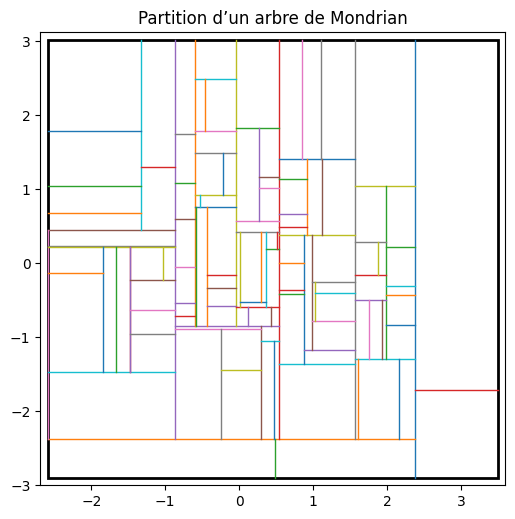

In [6]:
# Illustration (contours) de la fonction de prédiction dans le cas d'un espace de covariable de dimension 2

# Générer données 2D
X, y = make_regression(n_samples=200, n_features=2, noise=5.0, random_state=30)

# Importer le prédicteur
tree = SimpleMondrianTree(X, y, lifetime=5.0)

# Dessin
fig, ax = plt.subplots(figsize=(6, 6))
# ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20) # (Si on veut ajouter les points de données)
tree.draw(ax)
plt.title("Partition d’un arbre de Mondrian")
plt.show()


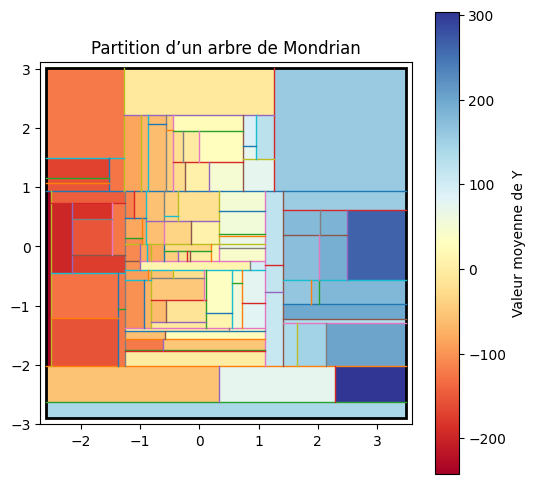

In [7]:
# Illustration (pleine) de la fonction de prédiction dans le cas d'un espace de covariable de dimension 2


# Générer données 2D
X, y = make_regression(n_samples=200, n_features=2, noise=5.0, random_state=30)

# Importer le prédicteur
tree = SimpleMondrianTree(X, y, lifetime=5.0)

# Définir bornes min/max pour normaliser les couleurs
vmin, vmax = y.min(), y.max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.RdYlBu

# Tracé
fig, ax = plt.subplots(figsize=(6,6))
tree.fill_cells(ax, cmap=plt.cm.RdYlBu, vmin=vmin, vmax=vmax)
tree.draw(ax)
plt.title("Partition d’un arbre de Mondrian")

# Ajout de la barre de couleurs
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Nécessaire même si non utilisée
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Valeur moyenne de Y")

plt.show()

### I.2 - Forêt

In [4]:
class SimpleMondrianForest(BaseEstimator) :
    def __init__(self, n_estimators=10, lifetime=5.0):
        self.n_estimators = n_estimators
        self.lifetime = lifetime
        self.trees = []

    def fit(self, X, y):
        self.trees = [
            SimpleMondrianTree(X, y, lifetime=self.lifetime)
            for _ in range(self.n_estimators)
        ]

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        #return predictions.mean(axis=0), predictions.std(axis=0)  # moyenne + incertitude
        return predictions.mean(axis=0)

In [9]:
forest = SimpleMondrianForest(n_estimators=1_000, lifetime=5.0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print("RMSE de la forêt de Mondrian :", root_mean_squared_error(y_test, y_pred))

RMSE de la forêt de Mondrian : 58.790944876127135


In [10]:
# Version normalisée
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)

forest = SimpleMondrianForest(n_estimators=1_000, lifetime=5.0)
forest.fit(X_train_minmax, y_train)
y_pred = forest.predict(min_max_scaler.transform(X_test))

print("RMSE de la forêt de Mondrian (avec variables normalisées) :", root_mean_squared_error(y_test, y_pred))

RMSE de la forêt de Mondrian (avec variables normalisées) : 58.396100134060916


In [11]:
# Comparaison rapide avec ce que prédit une forêt aléatoire classique, pour avoir l'ordre de grandeur

rf = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RMSE de la forêt aléatoire de Breiman :", root_mean_squared_error(y_test, y_pred))

RMSE de la forêt aléatoire de Breiman : 61.23969401027336


## II. Forêts STIT

### II.1 - Dessin

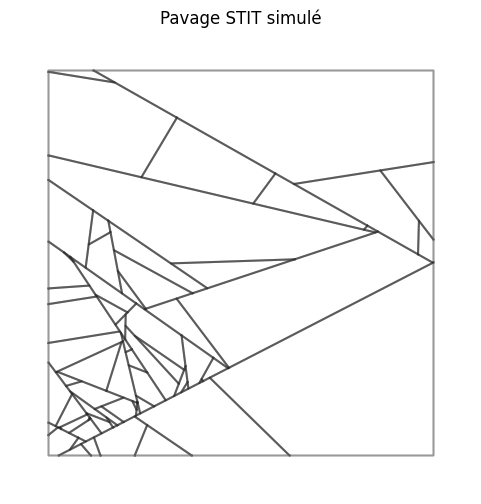

In [12]:
def random_cut_line(poly):
    """
    Génère une droite aléatoire (LineString) coupant le polygone poly.
    - Choix aléatoire d'orientation theta uniformément dans [0, pi)
    - Choix aléatoire de position r entre min et max projection
    """
    # Calcul projections des sommets
    coords = np.array(poly.exterior.coords)
    theta = np.random.uniform(0, np.pi)
    direction = np.array([np.cos(theta), np.sin(theta)])

    projections = coords @ direction  # produit scalaire
    r_min, r_max = projections.min(), projections.max()
    r = np.random.uniform(r_min, r_max)

    # La droite est l’ensemble des points x tels que <x, direction> = r
    # Pour tracer, on prend un segment très long perpendiculaire à direction
    perp = np.array([-direction[1], direction[0]])
    center = direction * r
    length = (r_max - r_min) * 2

    p1 = center + perp * length
    p2 = center - perp * length

    return LineString([p1, p2])

def stit_partition(poly, max_time, current_time=0):
    """
    Recursively subdivide poly until max_time is reached.
    Returns list of polygons (cells).
    """
    # Durée de vie exponentielle selon "taille" = périmètre
    perimeter = poly.length
    if perimeter == 0:
        return [poly]

    lifetime = np.random.exponential(scale=1/perimeter)
    if current_time + lifetime > max_time:
        return [poly]

    # Générer une droite de coupe aléatoire
    cut_line = random_cut_line(poly)

    # Couper la cellule
    splitted = split(poly, cut_line)
    if len(splitted.geoms) < 2:
        # pas coupé (rare), on renvoie la cellule
        return [poly]

    # Recurse on each part
    cells = []
    for part in splitted.geoms:
        cells.extend(stit_partition(part, max_time, current_time + lifetime))
    return cells

def plot_polygons(polygons, ax):
    for poly in polygons:
        x,y = poly.exterior.xy
        ax.plot(x, y, color="black", alpha=0.4)
        # ax.fill(x, y, color="black", alpha=0.4, edgecolor='black') pour des cases remplies en couleur

# Exemple d'utilisation
if __name__ == "__main__":
    #np.random.seed(0)
    initial_cell = box(0, 0, 1, 1)  # carré unité

    max_time = 10
    cells = stit_partition(initial_cell, max_time)

    fig, ax = plt.subplots(figsize=(6,6))
    plot_polygons(cells, ax)
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.1,1.1)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("Pavage STIT simulé")
    plt.show()


### II.2 - Arbre - cas isotrope (Approximation)

On fait ici seulement un cas particulier : le cas STIT isotrope. Est-ce qu'il est possible de faire avec une loi quelconque sur la sphère ? Comment tu codes une loi sur la sphère même ?

In [5]:
import numpy as np
import random
from scipy.spatial.distance import pdist, squareform

class SimpleSTITTree:
    def __init__(self, data, targets, lifetime=float('inf'), depth=0):
        self.data = np.array(data)
        self.targets = np.array(targets)
        self.lifetime = lifetime
        self.depth = depth
        self.n, self.d = self.data.shape
        dist_all = squareform(pdist(self.data))
        self.dist_max = np.max(dist_all)
        #self.center, r2 = miniball.get_bounding_ball(self.data)
        #self.radius = np.sqrt(r2)
        
        self.split_direction = None  # vecteur unitaire de coupe
        self.split_val = None  # valeur de la coupe sur la direction
        self.left = None
        self.right = None
        self.tau = None
        self.mean = self.targets.mean()
        self.var = self.targets.var() if self.n > 1 else 0.0
        
        self._split()
    
    def _split(self):
        # Calcul du polytope exact
        if self.n < self.d + 1:  # pas assez de points pour un polytope plein dimensionnel
            return
        
        rate = self.dist_max # Ou 2 self.dist_max ? Avec 1 on est plus proche du diamètre, non ?
        # rate = 2 * self.radius 
        if rate <= 0 or self.lifetime <= 0 or self.n < 2:
            return

        self.tau = random.expovariate(rate)
        if self.tau > self.lifetime:
            return

        direction = np.random.normal(size=self.d)
        direction /= np.linalg.norm(direction)

        projections = self.data @ direction
        min_proj, max_proj = np.min(projections), np.max(projections)

        if min_proj == max_proj:
            return None
        
        mu = np.random.uniform(0, 1)
        cut_val = (1 - mu) * min_proj + mu * max_proj

        self.split_direction = direction
        self.split_val = cut_val

        proj_data = self.data.dot(direction)
        mask = proj_data <= cut_val

        if mask.sum() == 0 or mask.sum() == self.n:
            return

        self.left = SimpleSTITTree(self.data[mask], self.targets[mask],
                                lifetime=self.lifetime - self.tau,
                                depth=self.depth + 1)
        self.right = SimpleSTITTree(self.data[~mask], self.targets[~mask],
                                    lifetime=self.lifetime - self.tau,
                                    depth=self.depth + 1)


    def predict_point(self, x, lifetime=None):
        if lifetime is None:
            lifetime = self.lifetime

        if self.split_direction is None or self.tau is None or self.tau > lifetime:
            return self.mean

        if np.dot(x, self.split_direction) <= self.split_val:
            if self.left is not None:
                return self.left.predict_point(x, lifetime - self.tau)
            else:
                return self.mean  # pas de sous-arbre, retourne la moyenne
        else:
            if self.right is not None:
                return self.right.predict_point(x, lifetime - self.tau)
            else:
                return self.mean  # pas de sous-arbre, retourne la moyenne
    
    def predict(self, X):
        return np.array([self.predict_point(x) for x in X])


In [14]:
# Evaluation sur des données de diabète - Cas de l'arbre de Mondrian


X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tree = SimpleSTITTree(X_train, y_train, lifetime = 20)
#print(tree.n_cuts, tree.radius)
y_pred = tree.predict(X_test)
y_pred_2 = np.array([np.mean(y_train)]*len(y_test)) # Constante égale à la moyenne
print("RMSE de l'arbre STIT :", root_mean_squared_error(y_test, y_pred))
print("RMSE par rapport à la moyenne simple :", root_mean_squared_error(y_test, y_pred_2)) # Erreur par rapport au prédicteur constant

RMSE de l'arbre STIT : 68.38692873710457
RMSE par rapport à la moyenne simple : 71.65740368288068


### II.3 - Forêt - cas isotrope (Approximation)

In [6]:
class SimpleSTITForest:
    def __init__(self, n_estimators=10, lifetime=5.0):
        self.n_estimators = n_estimators
        self.lifetime = lifetime
        self.trees = []

    def fit(self, X, y):
        self.trees = [
            SimpleSTITTree(X, y, lifetime=self.lifetime)
            for _ in range(self.n_estimators)
        ]

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return predictions.mean(axis=0), predictions.std(axis=0)  # moyenne + incertitude

In [16]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

forest = SimpleSTITForest(n_estimators=20, lifetime=20.0)
forest.fit(X_train, y_train)
y_pred, y_std = forest.predict(X_test)

print("RMSE (forest):", root_mean_squared_error(y_test, y_pred))

RMSE (forest): 60.074579799469376


In [17]:
# Comparaison rapide avec ce que prédit une forêt aléatoire classique, pour avoir l'ordre de grandeur
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rf = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RMSE maison:", root_mean_squared_error(y_test, y_pred))

RMSE maison: 61.23969401027336


### II. 4 - Arbre - Cas discret

In [7]:
class SimpleSTITTree_discrete : 

    # On utilise l'astuce de O'Reilly pour le cas discret : on se ramène à une forêt de Mondrian !

    def __init__(self, data, targets, directions, lifetime=float('inf'), depth=0) :

        self.data = np.array(data)
        self.targets = np.array(targets)
        self.lifetime = lifetime
        self.depth = depth
        self.n, self.d = self.data.shape
        self.n_directions = len(directions)
        self.matrix = np.array(directions)
        self.embedding = self.data @ self.matrix.T
        self.Mondrian = SimpleMondrianTree(self.embedding, 
                                           self.targets, 
                                           lifetime = self.lifetime/self.d, # ATTENTION, changement de valeur 
                                                        # du paramètre d'après les conventions Mondrian / STIT
                                                        # (Pour coller aux deux)
                                           depth = self.depth)

    def predict_point(self,x) :
        return self.Mondrian.predict_point(x @ self.matrix.T)

    def predict(self, X):
        return np.array([self.predict_point(x) for x in X])

In [19]:
# Evaluation sur des données de diabète - Cas de l'arbre de Mondrian

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

directions = [l.tolist()[0] for l in np.split(np.identity(X.shape[1]), X.shape[1])] # Pour faire la matrice identité

tree = SimpleSTITTree_discrete(X_train, y_train, directions, lifetime = 5 * X.shape[1])
#print(tree.n_cuts, tree.radius)
y_pred = tree.predict(X_test)
y_pred_2 = np.array([np.mean(y_train)]*len(y_test)) # Constante égale à la moyenne

print("RMSE de l'arbre STIT :", root_mean_squared_error(y_test, y_pred))
print("RMSE par rapport à la moyenne simple :", root_mean_squared_error(y_test, y_pred_2)) # Erreur par rapport au prédicteur constant

RMSE de l'arbre STIT : 74.36650175739553
RMSE par rapport à la moyenne simple : 71.65740368288068


In [20]:
liste_result = []
for _ in range(1_000):
    tree = SimpleSTITTree_discrete(X_train, y_train, directions, lifetime = 5 * X.shape[1])
    y_pred = tree.predict(X_test)
    liste_result.append(root_mean_squared_error(y_test, y_pred))
sum(liste_result)/len(liste_result)

69.69992045177179

In [8]:
# Une fonction qui permet de générer des directions aléatoires (en nombre "number", en dimension "shape")

def random_direction(number, shape):
    L = []
    for _ in range(number) : 
        direction = np.random.normal(size=shape)
        direction /= np.linalg.norm(np.random.normal(size=shape))
        L.append(direction)
    return L

In [22]:
# Evaluation sur des données de diabète - Cas de directions aléatoires

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Génération de directions aléatoires
directions = random_direction(X.shape[1], X.shape[1])

tree = SimpleSTITTree_discrete(X_train, y_train, directions, lifetime = 5 * X.shape[1])
y_pred = tree.predict(X_test)
y_pred_2 = np.array([np.mean(y_train)]*len(y_test))
print("RMSE de l'arbre STIT :", root_mean_squared_error(y_test, y_pred))
print("RMSE par rapport à la moyenne simple :", root_mean_squared_error(y_test, y_pred_2)) # donc qu'il faut absolument battre !

RMSE de l'arbre STIT : 72.34327823855871
RMSE par rapport à la moyenne simple : 71.65740368288068


In [23]:
# Avec des directions fixées
liste_result = []
for _ in range(1_000):
    tree = SimpleSTITTree_discrete(X_train, y_train, directions, lifetime = 5 * X.shape[1])
    y_pred = tree.predict(X_test)
    liste_result.append(root_mean_squared_error(y_test, y_pred))
sum(liste_result)/len(liste_result)

69.73600385035977

In [24]:
print(directions)

[array([-0.35805091, -0.26224498,  0.09172081,  0.4080298 ,  0.29608951,
       -0.23644485,  0.39558125,  0.27424639, -0.11733306,  0.23169558]), array([-0.37050971,  0.56983928, -0.00944248, -0.03140592, -0.4318232 ,
        0.21222095,  0.20132214, -0.30026902, -0.2573241 ,  0.1420626 ]), array([ 0.10689942,  0.0749616 ,  0.46856695, -0.19853527,  0.36152228,
       -0.21440244,  0.06694456, -0.11718472, -0.00982265,  0.00460126]), array([-0.22788869,  0.17320235, -0.00432563,  0.37457215,  0.1695849 ,
        0.2821015 , -0.11731051,  0.25104995, -0.0476285 ,  0.50619672]), array([ 0.14211736, -0.01609996, -0.09421109, -0.11077375,  0.15867974,
       -0.16843106,  0.07149853,  0.46272264, -0.27599567, -0.01162569]), array([-0.18011523, -0.53735735,  0.35714193,  0.12634505, -0.15236716,
       -0.58125784,  0.3290394 ,  0.29580967, -0.04145299,  0.11222412]), array([ 0.66383934,  0.85892074,  0.32339015, -1.02724429,  0.19985132,
       -0.82741807, -1.08370972,  0.29777689,  0.64

In [25]:
# En changeant de directions à chaque fois
liste_result = []
for _ in range(1_000):
    directions = random_direction(X.shape[1], X.shape[1])
    tree = SimpleSTITTree_discrete(X_train, y_train, directions, lifetime = 5 * X.shape[1])
    y_pred = tree.predict(X_test)
    liste_result.append(root_mean_squared_error(y_test, y_pred))
sum(liste_result)/len(liste_result)

70.93862563084355

### II.5 - Forêt - Cas discret

In [9]:
class SimpleSTITForest_discrete:
    def __init__(self, directions, n_estimators=10, lifetime=5.0):
        self.n_estimators = n_estimators
        self.lifetime = lifetime
        self.trees = []
        self.directions = directions

    def fit(self, X, y):
        self.trees = [
            SimpleSTITTree_discrete(X, y, self.directions, lifetime=self.lifetime)
            for _ in range(self.n_estimators)
        ]

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return predictions.mean(axis=0), predictions.std(axis=0)  # moyenne + incertitude

In [27]:
# Evaluation sur des données de diabète - Cas de forêt de Mondrian

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


directions = [l.tolist()[0] for l in np.split(np.identity(X.shape[1]), X.shape[1])]

forest = SimpleSTITForest_discrete(directions, n_estimators=1_000, lifetime=5 * X.shape[1])
forest.fit(X_train, y_train)
y_pred, y_std = forest.predict(X_test)

print("RMSE de la forêt STIT discrète :", root_mean_squared_error(y_test, y_pred))


RMSE de la forêt STIT discrète : 58.664200259643316


In [28]:
# Evaluation sur des données de diabète - Cas de directions aléatoires 

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Génération de directions aléatoires
directions = random_direction(30, X.shape[1])

forest = SimpleSTITForest_discrete(directions, n_estimators=1000, lifetime=5 * X.shape[1])
forest.fit(X_train, y_train)
y_pred, y_std = forest.predict(X_test)

print("RMSE de la forêt STIT discrète :", root_mean_squared_error(y_test, y_pred))

RMSE de la forêt STIT discrète : 59.04235334261572


## III. Forêts d'hyperplans de Poisson

### III.1 - Dessin

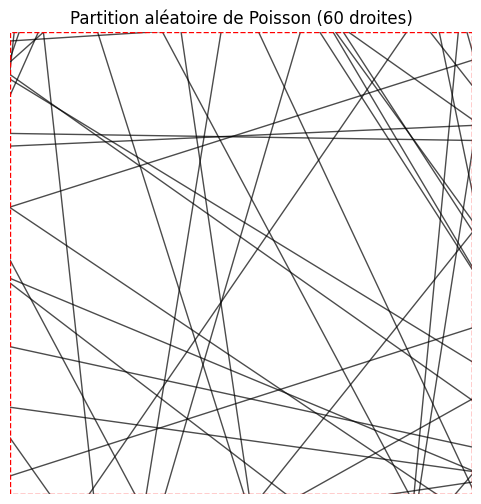

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_poisson_hyperplanes_2d(n_lines=50, radius=1.5, domain_size=1.0, seed=None):
    """
    Simule une partition de Poisson par hyperplans dans le carré [-domain_size, domain_size]^2.
    """
    if seed is not None:
        np.random.seed(seed)

    # Génère n droites selon le processus de Poisson homogène
    # PAS BON DU TOUT, déjà le nombre de ligne ne doit pas être fourni, bref c'est n'importe quoi
    thetas = np.random.uniform(0, np.pi, n_lines)           # orientation
    rs = np.random.uniform(-radius, radius, n_lines)        # distance signée à l'origine

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-domain_size, domain_size)
    ax.set_ylim(-domain_size, domain_size)
    ax.set_aspect('equal')

    # Tracer chaque droite dans la fenêtre d’observation
    for r, theta in zip(rs, thetas):
        # Droite en coordonnées normales : x cos θ + y sin θ = r
        # => y = (r - x cos θ) / sin θ
        if np.abs(np.sin(theta)) > 1e-6:
            x_vals = np.linspace(-domain_size * 1.5, domain_size * 1.5, 100)
            y_vals = (r - x_vals * np.cos(theta)) / np.sin(theta)
        else:
            # Presque verticale : x = r / cos(θ)
            x_fixed = r / np.cos(theta)
            x_vals = np.full(100, x_fixed)
            y_vals = np.linspace(-domain_size * 1.5, domain_size * 1.5, 100)

        ax.plot(x_vals, y_vals, color='black', linewidth=1, alpha=0.7)

    # Dessine le domaine
    ax.plot([-domain_size, -domain_size, domain_size, domain_size, -domain_size],
            [-domain_size, domain_size, domain_size, -domain_size, -domain_size],
            'r--', linewidth=1)
    ax.set_title(f"Partition aléatoire de Poisson ({n_lines} droites)")
    plt.axis('off')
    plt.show()

simulate_poisson_hyperplanes_2d(n_lines=60, radius=2, domain_size=1, seed=42)


### III.2 - Arbre - Cas isotrope

In [10]:
def locate_cell(x, hyperplanes):
    """
    Repère dans quelle cellule du pavage défini par un ensemble d'hyperplans se trouve un point x.

    Paramètres
    ----------
    x : array-like, shape (n,)
        Le point dans ℝⁿ.

    hyperplanes : list of tuples (w, b)
        Liste d'hyperplans, chaque hyperplan étant défini par un tuple :
        - w : vecteur normal (array-like de taille n)
        - b : scalaire

    Retour
    ------
    cell_signature : tuple of int
        Pour chaque hyperplan, +1 si le point est au-dessus, -1 si en dessous, 0 si sur l'hyperplan.
    """
    x = np.asarray(x)
    cell_signature = []

    for w, b in hyperplanes:
        w = np.asarray(w)
        dot = np.dot(w, x) + b
        side = np.sign(dot)
        # S'assurer que le 0 est bien considéré
        if np.isclose(dot, 0.0):
            side = 0
        cell_signature.append(int(side))

    return tuple(cell_signature)


In [255]:
class PoissonHyperplaneTree:
    def __init__(self, data, targets, lifetime=float('inf')):
        self.data = np.array(data)
        self.targets = np.array(targets)
        self.lifetime = lifetime
        self.n, self.d = self.data.shape
        self.hyperplanes = []
        self.positions = None
        self.mean = statistics.mean(self.targets)

        # self.bounds = np.column_stack((self.data.min(axis=0), self.data.max(axis=0)))
        self.center, r2 = miniball.get_bounding_ball(self.data)
        self.radius = np.sqrt(r2)
        
        self.rate = self._compute_rate()
        
        self.n_cuts = np.random.poisson(self.rate * self.lifetime)

        self._split_multiple()

    def _compute_rate(self):
        # On prend comme fenêtre d'observation la plus petite boule centrée en 0 qui contient les données
        rate = 2*self.radius
        return rate

    def _split_multiple(self):

        if self.rate <= 0 or self.lifetime <= 0 or self.n < 2 :
            return

        for _ in range(self.n_cuts) :
    
            # Pour chaque coupe, essayer de couper et créer sous-arbres
            direction = np.random.normal(size=self.d)
            direction /= np.linalg.norm(direction)
            split_val = random.uniform(-self.radius, self.radius)
            self.hyperplanes.append((direction, -np.dot(direction,self.center) - split_val))
        
        self.positions = [(self.data[i], self.targets[i], locate_cell(self.data[i], self.hyperplanes)) 
                          for i in range(len(self.data))] 

    def predict_point(self, x):
        target_cell = locate_cell(x, self.hyperplanes)
        points_in_target_cell = [y for data, y, cell in self.positions if cell == target_cell]
        if points_in_target_cell == [] : 
            return [self.mean]
        else : 
            return [sum(points_in_target_cell)/len(points_in_target_cell)]

    def predict(self, X):
        return np.array([self.predict_point(x) for x in X])

    def draw(self, ax=None):
        if self.d != 2:
            raise ValueError("Le dessin n'est disponible que pour des données 2D.")

        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))

        # 1. Tracer les points de données
        ax.scatter(self.data[:, 0], self.data[:, 1], color='blue', s=10, label='Données')

        # 2. Tracer le cercle de rayon `self.radius` centré en 0
        circle = plt.Circle(self.center, self.radius, color='gray', fill=False, linestyle='--', label=f"Cercle (rayon={self.radius:.2f})")
        ax.add_patch(circle)

        # 3. Tracer tous les hyperplans (dans self.hyperplanes)
        if hasattr(self, 'hyperplanes'):
            for i, (w, b) in enumerate(self.hyperplanes):
                w = np.asarray(w)
                norm = np.linalg.norm(w)
                if norm == 0:
                    continue
                w = w / norm  # Normalisation pour stabilité

                # On veut tracer la droite : w[0] * x + w[1] * y + b = 0
                if abs(w[1]) > 1e-10:
                    x_vals = np.linspace(self.center[0]-self.radius * 1.1, self.center[0]+self.radius * 1.1, 500)
                    y_vals = -(w[0] * x_vals + b) / w[1]
                else:
                    x_val = -b / w[0]
                    x_vals = np.full(2, x_val)
                    y_vals = np.linspace(-self.radius, self.radius, 2)

                ax.plot(x_vals, y_vals, 'r-', linewidth=1, alpha=0.6)

        # Mise en forme
        ax.set_xlim(self.center[0]-self.radius * 1.1, self.center[0]+self.radius * 1.1)
        ax.set_ylim(self.center[1]-self.radius * 1.1, self.center[1]+self.radius * 1.1)
        ax.set_aspect('equal')
        ax.set_title("Pavage par hyperplans (2D)")
        ax.legend()
        return ax



In [32]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import root_mean_squared_error

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tree = PoissonHyperplaneTree(X_train, y_train, lifetime=10)
print(tree.n_cuts, tree.radius)
y_pred = tree.predict(X_test)
y_pred_2 = np.array([np.mean(y_train)]*len(y_test))
print("RMSE Poisson tree:", root_mean_squared_error(y_test, y_pred))
print("RMSE moyenne simple:", root_mean_squared_error(y_test, y_pred_2)) # donc qu'il faut absolument battre !

5 0.26993942581678104
RMSE Poisson tree: 81.89753646039765
RMSE moyenne simple: 71.65740368288068


In [33]:
liste_result = []
for _ in range(100):
    tree = PoissonHyperplaneTree(X_train, y_train, lifetime = 5)
    y_pred = tree.predict(X_test)
    liste_result.append(root_mean_squared_error(y_test, y_pred))
sum(liste_result)/len(liste_result)

70.66799918234523

In [34]:
miniball.get_bounding_ball(X_train)

(array([-0.00903681,  0.00797139,  0.00703693, -0.00959745,  0.0278749 ,
         0.03454349, -0.00057479,  0.04723889,  0.00432225,  0.00596028]),
 np.float64(0.0728672936102934))

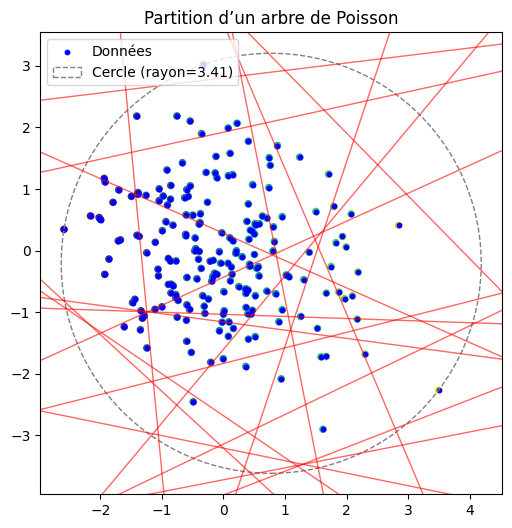

In [35]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

# Générer données 2D
X, y = make_regression(n_samples=200, n_features=2, noise=5.0, random_state=30)

tree = PoissonHyperplaneTree(X, y, lifetime=3)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
tree.draw(ax)
plt.title("Partition d’un arbre de Poisson")
plt.show()

### III.3 - Forêt - Cas isotrope

In [252]:
class SimplePoissonForest:
    def __init__(self, n_estimators=10, lifetime=5.0):
        self.n_estimators = n_estimators
        self.lifetime = lifetime
        self.trees = []

    def fit(self, X, y):
        self.trees = [
            PoissonHyperplaneTree(X, y, lifetime=self.lifetime)
            for _ in range(self.n_estimators)
        ]

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return predictions.mean(axis=0), predictions.std(axis=0)  # moyenne + incertitude

In [37]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

forest = SimplePoissonForest(n_estimators=100, lifetime=10)
forest.fit(X_train, y_train)
y_pred, y_std = forest.predict(X_test)

print("RMSE (forest):", root_mean_squared_error(y_test, y_pred))

RMSE (forest): 66.23529295540024


In [38]:
# Comparaison rapide avec ce que prédit une forêt aléatoire classique, pour avoir l'ordre de grandeur
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RMSE maison:", root_mean_squared_error(y_test, y_pred))

RMSE maison: 61.23969401027336


### III.4 - Arbre - Cas discret

In [276]:
class PoissonHyperplaneTree_discrete:
    def __init__(self, data, targets, directions, poids = None, lifetime=float('inf')):
        self.data = np.array(data)
        self.targets = np.array(targets)
        self.lifetime = lifetime
        self.n, self.d = self.data.shape
        self.hyperplanes = []
        self.directions = directions
        self.positions = None
        self.poids = poids # vecteur de taille le nombre de directions ; donne les 
        self.mean = statistics.mean(self.targets)

        # self.bounds = np.column_stack((self.data.min(axis=0), self.data.max(axis=0)))
        self.center, r2 = miniball.get_bounding_ball(self.data)
        self.radius = np.sqrt(r2)
        
        self.rate = self._compute_rate()
        
        self.n_cuts = np.random.poisson(self.rate * self.lifetime)

        self._split_multiple()

    def _compute_rate(self):
        rate = 2*self.radius
        return rate

    def _split_multiple(self):

        poids = self.poids 
        if poids is None : 
            # Cas uniforme
            l = len(self.directions)
            poids = [1/l for _ in range(l)]

        if self.rate <= 0 or self.lifetime <= 0 or self.n < 2 :
            return

        for _ in range(self.n_cuts) :
            direction = self.directions[np.random.choice(len(self.directions), p = poids)]
            split_val = random.uniform(-self.radius, self.radius)
            self.hyperplanes.append((direction, -np.dot(direction,self.center) - split_val))
        
        self.positions = [(self.data[i], self.targets[i], locate_cell(self.data[i], self.hyperplanes)) 
                          for i in range(len(self.data))] 

    def predict_point(self, x):
        target_cell = locate_cell(x, self.hyperplanes)
        points_in_target_cell = [y for data, y, cell in self.positions if cell == target_cell]
        if points_in_target_cell == [] : 
            return self.mean
        else : 
            return sum(points_in_target_cell)/len(points_in_target_cell)

    def predict(self, X):
        return np.array([self.predict_point(x) for x in X])

    def draw(self, ax=None):
        if self.d != 2:
            raise ValueError("Le dessin n'est disponible que pour des données 2D.")

        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))

        # 1. Tracer les points de données
        ax.scatter(self.data[:, 0], self.data[:, 1], color='blue', s=10, label='Données')

        # 2. Tracer le cercle de rayon `self.radius` centré en 0
        circle = plt.Circle(self.center, self.radius, color='gray', fill=False, linestyle='--', label=f"Cercle (rayon={self.radius:.2f})")
        ax.add_patch(circle)

        # 3. Tracer tous les hyperplans (dans self.hyperplanes)
        if hasattr(self, 'hyperplanes'):
            for i, (w, b) in enumerate(self.hyperplanes):
                w = np.asarray(w)
                norm = np.linalg.norm(w)
                if norm == 0:
                    continue
                w = w / norm  # Normalisation pour stabilité

                # On veut tracer la droite : w[0] * x + w[1] * y + b = 0
                if abs(w[1]) > 1e-10:
                    x_vals = np.linspace(self.center[0]-self.radius * 1.1, self.center[0]+self.radius * 1.1, 500)
                    y_vals = -(w[0] * x_vals + b) / w[1]
                else:
                    x_val = -b / w[0]
                    x_vals = np.full(2, x_val)
                    y_vals = np.linspace(-self.radius, self.radius, 2)

                ax.plot(x_vals, y_vals, 'r-', linewidth=1, alpha=0.6)

        # Mise en forme
        ax.set_xlim(self.center[0]-self.radius * 1.1, self.center[0]+self.radius * 1.1)
        ax.set_ylim(self.center[1]-self.radius * 1.1, self.center[1]+self.radius * 1.1)
        ax.set_aspect('equal')
        ax.set_title("Pavage par hyperplans (2D)")
        ax.legend()
        return ax


In [40]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

directions = [l.tolist()[0] for l in np.split(np.identity(X.shape[1]), X.shape[1])]

tree = PoissonHyperplaneTree_discrete(X_train, y_train, directions, lifetime = 5)
print(tree.n_cuts, tree.radius)
y_pred = tree.predict(X_test)
y_pred_2 = np.array([np.mean(y_train)]*len(y_test))
print("RMSE Poisson tree:", root_mean_squared_error(y_test, y_pred))
print("RMSE moyenne simple:", root_mean_squared_error(y_test, y_pred_2)) # donc qu'il faut absolument battre !

4 0.269939425816781
RMSE Poisson tree: 70.87117353481439
RMSE moyenne simple: 71.65740368288068


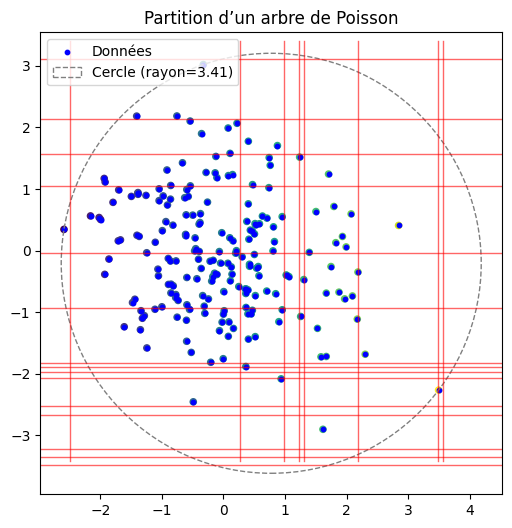

In [41]:
# Fonction draw à modifier totalement

from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

# Générer données 2D
X, y = make_regression(n_samples=200, n_features=2, noise=5.0, random_state=30)

directions = [l.tolist()[0] for l in np.split(np.identity(X.shape[1]), X.shape[1])]

tree = PoissonHyperplaneTree_discrete(X, y, directions, lifetime=3)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
tree.draw(ax)
plt.title("Partition d’un arbre de Poisson")
plt.show()

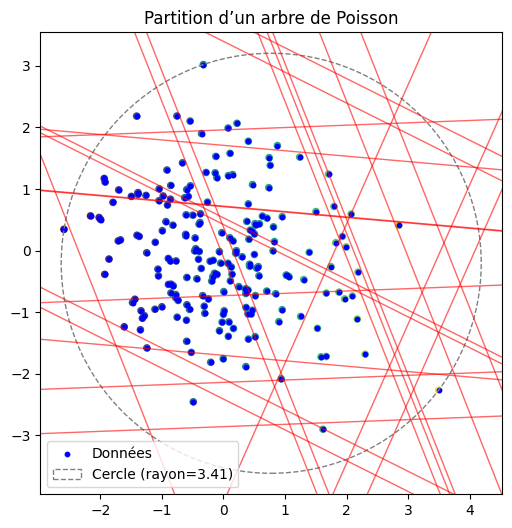

In [42]:
directions = random_direction(5, X.shape[1])
tree = PoissonHyperplaneTree_discrete(X, y, directions, lifetime=6)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
tree.draw(ax)
plt.title("Partition d’un arbre de Poisson")
plt.show()

### III.5 - Forêt - Cas discret

In [277]:
class SimplePoissonForest_discrete :
    def __init__(self, directions, n_estimators=10, lifetime=5.0):
        self.n_estimators = n_estimators
        self.lifetime = lifetime
        self.trees = []
        self.directions = directions

    def fit(self, X, y):
        self.trees = [
            PoissonHyperplaneTree_discrete(X, y, directions = self.directions, lifetime=self.lifetime)
            for _ in range(self.n_estimators)
        ]

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return predictions.mean(axis=0), predictions.std(axis=0)  # moyenne + incertitude

In [44]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

directions = random_direction(5, X.shape[1])
tree = PoissonHyperplaneTree_discrete(X, y, directions, lifetime=6)

forest = SimplePoissonForest_discrete(directions, n_estimators=1000, lifetime=15)
forest.fit(X_train, y_train)
y_pred, y_std = forest.predict(X_test)

print("RMSE (forest):", root_mean_squared_error(y_test, y_pred))

RMSE (forest): 64.437916472218


## IV. Forêts de Poisson-Voronoi

### IV.1 - Dessin

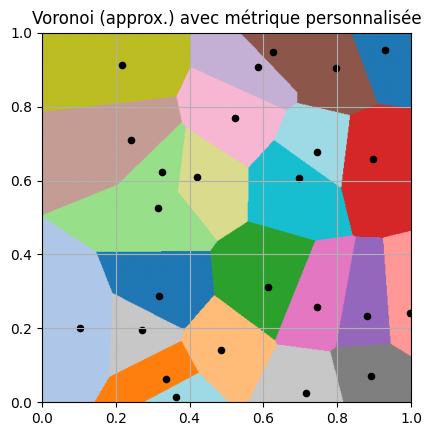

In [45]:
def voronoi_distance_based(points, metric='euclidean', resolution=500, xlim=(0,1), ylim=(0,1)):
    from scipy.spatial.distance import cdist

    # Grille d’évaluation
    x = np.linspace(xlim[0], xlim[1], resolution)
    y = np.linspace(ylim[0], ylim[1], resolution)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Distance entre chaque pixel et les sites
    distances = cdist(grid_points, points, metric=metric)
    closest = np.argmin(distances, axis=1)

    # Image de Voronoi
    voronoi_image = closest.reshape((resolution, resolution))
    return voronoi_image

def plot_colored_voronoi_image(image, points, xlim=(0,1), ylim=(0,1)):
    plt.imshow(image, origin='lower', extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='tab20')
    plt.scatter(points[:, 0], points[:, 1], c='black', s=20)
    plt.title("Voronoi (approx.) avec métrique personnalisée")
    plt.grid(True)
    plt.show()

def generate_points(n=15, xlim=(0, 1), ylim=(0, 1), seed=None):
    rng = np.random.default_rng(seed)
    x = rng.uniform(xlim[0], xlim[1], n)
    y = rng.uniform(ylim[0], ylim[1], n)
    return np.column_stack((x, y))

points = generate_points(25)
img = voronoi_distance_based(points, metric='euclidean')  # 'euclidean', 'chebyshev', etc.
plot_colored_voronoi_image(img, points)

### IV.2 - Arbre

In [15]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state

class PoissonVoronoiTree:
    def __init__(self, data, targets, lifetime=100, bounding_box=None, draw = False, random_state=None, ord = None):
        self.data = np.array(data)
        self.targets = np.array(targets)
        self.n, self.d = self.data.shape
        self.draw = draw
        self.random_state = check_random_state(random_state)
        self.ord = ord # Choix de la métrique utilisée. Choix entre {int, float, inf, -inf}
        # (voir https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

        self.lifetime = lifetime

        # Définir le domaine (bounding box)
        if bounding_box is None:
            mins = self.data.min(axis=0)
            maxs = self.data.max(axis=0)
            self.bounding_box = np.column_stack((mins, maxs))
        else:
            self.bounding_box = np.array(bounding_box)
        #mins = self.bounding_box[:, 0]
        #maxs = self.bounding_box[:, 1]
        #side_lengths = maxs - mins
        #self.volume = np.prod(side_lengths)

        #self.n_sites = np.random.poisson(self.volume * self.lifetime)

        self.n_sites = max(np.random.poisson(self.lifetime), 1)
        
        # Générer les sites du processus Poisson (uniforme dans le bounding box)
        self.sites = self.random_state.uniform(low=self.bounding_box[:,0], 
                                       high=self.bounding_box[:,1], 
                                       size=(self.n_sites, self.d))
        
        # Calculer le diagramme de Voronoi sur les sites, pour le dessin
        if draw :
            self.voronoi = Voronoi(self.sites)
        
        # Associer chaque point à son site le plus proche
        self.assignments = self._assign_points()
        
        # Calculer la moyenne des cibles dans chaque cellule Voronoi
        self.site_means = self._compute_site_means()
    
    def _assign_points(self):
        # Calculer les distances entre chaque point et chaque site
        dists = np.linalg.norm(self.data[:, None, :] - self.sites[None, :, :], axis=2, ord = self.ord)
        # Pour chaque point, index du site le plus proche
        return np.argmin(dists, axis=1)
    
    def _compute_site_means(self):
        means = np.zeros(self.sites.shape[0])
        for i in range(self.sites.shape[0]):
            mask = self.assignments == i
            if np.sum(mask) > 0:
                means[i] = self.targets[mask].mean()
            else:
                means[i] = 0.0  # ou np.nan, au choix
        return means
    
    def predict(self, X):
        X = np.array(X)
        dists = np.linalg.norm(X[:, None, :] - self.sites[None, :, :], axis=2, ord = self.ord)
        assignments = np.argmin(dists, axis=1)
        return self.site_means[assignments]
    
    def plot(self):
        if self.d != 2:
            print("Le plot est uniquement supporté en 2D.")
            return
        if not self.draw :
            print("Attention ! Tu dois préciser draw=True")
            return
        if self.ord != None and self.ord != 2 :
            print('Désolé, dessin indisponible avec cette distance pour le moment')
            return 
        fig, ax = plt.subplots()
        voronoi_plot_2d(self.voronoi, ax=ax, show_vertices=False, line_colors='orange')
        ax.scatter(self.data[:,0], self.data[:,1], c='blue', s=10, label='Data')
        ax.scatter(self.sites[:,0], self.sites[:,1], c='red', marker='x', label='Sites')
        ax.legend()
        plt.show()


Limitations et extensions
- Ce pavage n’est pas un arbre récursif, c’est un pavage global.
- Pour haute dimension, la complexité de Voronoi explose, donc il vaut mieux réduire la dimension.
- On peut améliorer en adaptant le nombre de sites, ou en pondérant les sites, etc.
- Pour une vraie version arborescente, il faudrait imbriquer plusieurs tessellations.

RMSE Poisson-Voronoi: 70.72305848556012


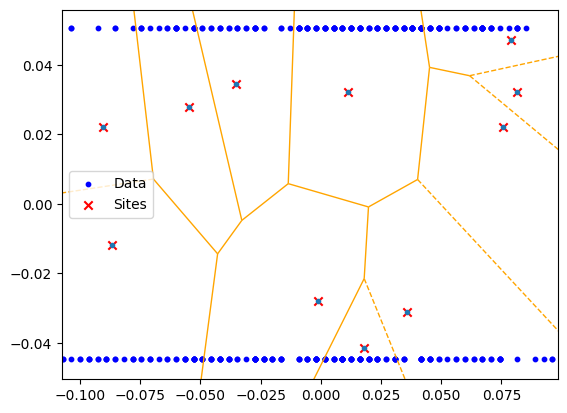

In [47]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Note : Pour un exemple simple, on prend seulement 2 dimensions (ex: 0 et 1) car la visualisation Voronoi 2D est possible
X_train_2d = X_train[:, :2]
X_test_2d = X_test[:, :2]

pv_tree = PoissonVoronoiTree(X_train_2d, y_train, lifetime=10, draw = True)
y_pred = pv_tree.predict(X_test_2d)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

print("RMSE Poisson-Voronoi:", rmse(y_test, y_pred))

# Pour visualiser
pv_tree.plot()


In [48]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import inf

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Note : Pour un exemple simple, on prend seulement 2 dimensions (ex: 0 et 1) car la visualisation Voronoi 2D est possible
model = PoissonVoronoiTree(X_train, y_train, lifetime = 100, ord = 1)
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))

RMSE: 70.54029586987333


### IV.3 - Forêt

In [16]:
class VoronoiForestRegressor:
    def __init__(self, n_estimators=100, lifetime =50, random_state=None, bounding_box=None, ord = None):
        self.n_estimators = n_estimators
        self.lifetime = lifetime
        self.random_state = check_random_state(random_state)
        self.bounding_box = bounding_box
        self.ord = ord
    
    def fit(self, X, y):
        self.trees_ = []
        for i in range(self.n_estimators):
            tree = PoissonVoronoiTree(
                data = X, 
                targets = y,
                lifetime=self.lifetime, 
                random_state=self.random_state.randint(0, 1e6),
                bounding_box= self.bounding_box,
                ord = self.ord
            )
            self.trees_.append(tree)
        return self

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees_])
        return preds.mean(axis=0)


In [50]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

X, y = make_regression(n_samples=1000, n_features=2, noise=10.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = VoronoiForestRegressor(n_estimators=50, lifetime=50, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))


RMSE: 11.893528948132886


In [51]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Note : Pour un exemple simple, on prend seulement 2 dimensions (ex: 0 et 1) car la visualisation Voronoi 2D est possible
model = VoronoiForestRegressor(n_estimators=50, lifetime=50, ord = inf)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))

RMSE: 60.9221894011629


## V. Forêts de Poisson-Delaunay

### V.1 - Dessin

### V.2 - Arbre 

In [17]:
import numpy as np
from scipy.spatial import Delaunay
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import check_random_state

class DelaunayTreeRegressor:
    def __init__(self, lifetime=50, random_state=None, padding = 2, printo = False):
        self.lifetime = lifetime
        self.printo = printo
        self.random_state = check_random_state(random_state)
        self.padding = padding # % de marge autour de X (exemple : 0.05 = 5%)
        # Donc par défaut, padding = 2 signifie 200%
        self.n_cells = max(np.random.poisson(lifetime),9)
        if self.printo :
            print("Nombre de points de Poisson :", self.n_cells)

    def fit(self, X, y):
        xmin_0, xmax_0 = np.min(X, axis=0), np.max(X, axis=0)
        range_ = xmax_0 - xmin_0
        xmin = xmin_0 - self.padding * range_
        xmax = xmax_0 + self.padding * range_

        self.points_ = self.random_state.uniform(
            low=xmin,
            high=xmax,
            size=(self.n_cells, X.shape[1])
        )

        liste = []
        for point in self.points_ : 
            g = True
            for i in range(X.shape[1]):
                if xmin_0[i]>= point[i] or xmax_0[i]<= point[i] :
                    g = False
            if g :
                liste.append(self.points_[i])
        
        if self.printo : 
            print("Points dans la boîte :", len(liste))

        # Triangulation de Delaunay
        self.tri_ = Delaunay(self.points_)
        self.y = y
        if self.printo : 
            print("Nombre de simplexes", self.tri_.nsimplex)

        # Pour chaque simplexe, on stocke les y moyens des X_train qui y tombent
        self.simplex_values_ = {}
        simplices = self.tri_.find_simplex(X)

        for i in range(self.tri_.nsimplex):
            idx = np.where(simplices == i)[0]
            if len(idx) > 0:
                self.simplex_values_[i] = np.mean(y[idx])
            else:
                mean_y = sum(self.y) / len(self.y)
                self.simplex_values_[i] = mean_y  # valeur par défaut

        return self

    def predict(self, X):
        # On récupère le numéro du simplexe de X
        simplices = self.tri_.find_simplex(X)
        # On trouve les valeurs associées
        values = list(self.simplex_values_.values())
        mean_y = sum(self.y) / len(self.y)  # calcul manuel au lieu de np.mean
        if self.printo :
            print("Simplices :", simplices)
            print("Values :", values)
            print("Dico : ", self.simplex_values_)
        return np.array([
            self.simplex_values_.get(s, mean_y) for s in simplices
        ])
    
    
    def plot(self, X, y, resolution=100, show_predictions=True):
        """
        Affiche la triangulation de Delaunay et (optionnellement) la carte de prédiction.

        Paramètres :
        - X : ndarray de forme (n_samples, 2)
        - y : ndarray de forme (n_samples,)
        - resolution : densité de la grille pour la carte
        - show_predictions : bool, si True montre une carte de prédiction
        """
        if X.shape[1] != 2:
            raise ValueError("La visualisation ne fonctionne que pour des données 2D.")

        plt.figure(figsize=(8, 6))

        # Triangulation
        plt.triplot(self.points_[:, 0], self.points_[:, 1], self.tri_.simplices, color='gray', alpha=0.6)
        plt.scatter(self.points_[:, 0], self.points_[:, 1], c='k', s=20, label="Sites (aléatoires)")

        # Données d'entraînement
        scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, edgecolor='k', label="X train (y)")
        plt.colorbar(scatter, label="Valeur cible y")

        if show_predictions:
            # Grille de prédiction
            x_min, x_max = X[:, 0].min(), X[:, 0].max()
            y_min, y_max = X[:, 1].min(), X[:, 1].max()
            xx, yy = np.meshgrid(
                np.linspace(x_min, x_max, resolution),
                np.linspace(y_min, y_max, resolution)
            )
            grid = np.c_[xx.ravel(), yy.ravel()]
            zz = self.predict(grid).reshape(xx.shape)

            plt.contourf(xx, yy, zz, alpha=0.4, cmap='coolwarm', levels=20)

        plt.legend()
        plt.title("Tessellation de Delaunay et prédiction")
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.axis('equal')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [53]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import numpy as np
from numpy import inf

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = DelaunayTreeRegressor(lifetime = 17, padding = 3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_test,y_pred)

print("RMSE:", root_mean_squared_error(y_test, y_pred))

[321. 215. 127.  64. 175. 275. 179. 232. 142.  99. 252. 174. 129.  74.
 264.  49.  86.  75. 101. 155. 170. 276. 110. 136.  68. 128. 103.  93.
 191. 196. 217. 181. 168. 200. 219. 281. 151. 257.  49. 198.  96. 179.
  95. 198. 244.  89. 214. 182.  84. 270. 156. 138. 113. 131. 195. 171.
 122.  61. 230. 235.  52. 121. 144. 107. 132. 302.  53. 317. 137.  57.
  98. 170.  88.  90.  67. 163. 104. 186. 180. 283. 141. 150.  47. 297.
 104.  49. 103. 142.  59.] [159.20512821 151.60623229 115.22916667 151.60623229 151.60623229
 151.60623229 151.60623229 159.20512821 151.60623229 151.60623229
  69.66666667 106.11111111 115.22916667 151.60623229 151.60623229
 115.22916667 151.60623229 151.60623229 106.11111111 151.60623229
 115.22916667 151.60623229 159.20512821 106.11111111 151.60623229
 151.60623229 151.60623229 151.60623229 151.60623229 109.33333333
 222.22222222 151.60623229  69.66666667 151.60623229 151.60623229
 151.60623229 151.60623229 115.22916667 151.60623229 151.60623229
 151.60623229 150.4

In [54]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

X, y = make_regression(n_samples=1000, n_features=4, noise=10.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = DelaunayTreeRegressor(lifetime = 10, padding = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(y_pred, y_test)
print("RMSE:", root_mean_squared_error(y_test, y_pred))


[ -89.30105969   43.77712898   33.0343076    33.0343076   -89.30105969
   33.0343076    -6.02774283   43.77712898   33.0343076    43.77712898
  125.89201334  -89.30105969 -133.25453721 -133.25453721   33.0343076
   -6.02774283   -6.02774283   -6.02774283  -89.30105969   33.0343076
   43.77712898   43.77712898   33.0343076   -89.30105969   43.77712898
   43.77712898   33.0343076    43.77712898   43.77712898  -89.30105969
   33.0343076    -6.02774283   -6.02774283   43.77712898   -6.02774283
   43.77712898   43.77712898   43.77712898  125.89201334   33.0343076
   43.77712898   43.77712898   43.77712898   33.0343076   -89.30105969
   33.0343076    -6.02774283  125.89201334   43.77712898  125.89201334
   33.0343076    -6.02774283   43.77712898 -133.25453721   -6.02774283
   33.0343076    33.0343076    43.77712898   43.77712898   43.77712898
   33.0343076    33.0343076    43.77712898 -265.91565886   43.77712898
   33.0343076    -6.02774283   43.77712898   33.0343076    43.77712898
   -6.027

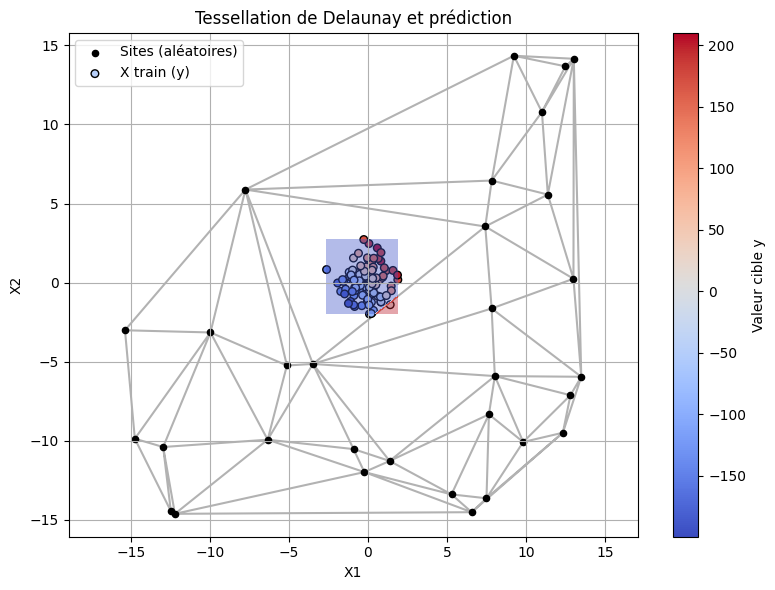

In [55]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

# Générer des données 2D pour la régression
X, y = make_regression(n_samples=100, n_features=2, noise=15.0, random_state=42)

# Initialiser et entraîner le modèle
reg = DelaunayTreeRegressor(lifetime =30, padding =3)
reg.fit(X, y)

# Afficher la triangulation et la carte de prédiction
reg.plot(X, y)

### V.3 - Forêt

In [18]:
class DelaunayForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=10, lifetime =30, random_state=None, padding = 2):
        self.n_estimators = n_estimators
        self.lifetime = lifetime
        self.random_state = check_random_state(random_state)
        self.padding = padding

    def fit(self, X, y):
        self.trees_ = []
        for _ in range(self.n_estimators):
            tree = DelaunayTreeRegressor(
                lifetime=self.lifetime,
                random_state=self.random_state.randint(0, 1e6),
                padding = self.padding
            )
            tree.fit(X, y)
            self.trees_.append(tree)
        return self

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees_])
        return np.mean(preds, axis=0)


In [57]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

X, y = make_regression(n_samples=1000, n_features=2, noise=10.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = DelaunayForestRegressor(n_estimators=10, lifetime=36, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))


RMSE: 22.736524498986157


In [58]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import numpy as np
from numpy import inf

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = DelaunayForestRegressor(n_estimators=20, lifetime = 30, random_state=42, padding = 2.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))

RMSE: 61.09922322168567


## VI. Forêts de Poisson - Laguerre

### VI.1 - Dessin

### VI.2 - Arbre 

In [19]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import check_random_state

class PoissonLaguerreTreeRegressor:
    def __init__(self, n_cells=10, random_state=None):
        self.n_cells = n_cells
        self.random_state = random_state

    def fit(self, X, y):
        rng = check_random_state(self.random_state)
        n_samples, n_features = X.shape

        # Générer des sites et des poids aléatoires
        self.sites_ = rng.uniform(X.min(axis=0), X.max(axis=0), size=(self.n_cells, n_features))
        self.weights_ = rng.uniform(0, 1.0, size=self.n_cells)

        # Assigner chaque point à une cellule
        distances = np.array([
            np.sum((X - site)**2, axis=1) - weight
            for site, weight in zip(self.sites_, self.weights_)
        ])
        self.assignments_ = np.argmin(distances, axis=0)

        # Calculer la moyenne cible dans chaque cellule
        self.cell_values_ = np.array([
            y[self.assignments_ == i].mean() if np.any(self.assignments_ == i) else 0.0
            for i in range(self.n_cells)
        ])
        return self

    def predict(self, X):
        distances = np.array([
            np.sum((X - site)**2, axis=1) - weight
            for site, weight in zip(self.sites_, self.weights_)
        ])
        assignments = np.argmin(distances, axis=0)
        return self.cell_values_[assignments]

In [18]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import numpy as np
from numpy import inf

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = PoissonLaguerreTreeRegressor(n_cells=40, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))

RMSE: 69.50630756920175


### VI.3 - Forêt

In [20]:
class PoissonLaguerreForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=10, n_cells=10, random_state=None):
        self.n_estimators = n_estimators
        self.n_cells = n_cells
        self.random_state = random_state

    def fit(self, X, y):
        self.trees_ = []
        rng = check_random_state(self.random_state)
        for i in range(self.n_estimators):
            tree = PoissonLaguerreTreeRegressor(
                n_cells=self.n_cells,
                random_state=None
            )
            tree.fit(X, y)
            self.trees_.append(tree)
        return self

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees_])
        return preds.mean(axis=0)


In [62]:
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

# Génération de données
X, y = make_regression(n_samples=500, n_features=2, noise=10, random_state=42)

# Apprentissage
model = PoissonLaguerreForestRegressor(n_estimators=20, n_cells=30, random_state=42)
model.fit(X, y)

# Prédiction
y_pred = model.predict(X)
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))


RMSE: 10.581040021169203


In [63]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import numpy as np
from numpy import inf

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = PoissonLaguerreForestRegressor(n_estimators= 1_000, n_cells=30, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))

RMSE: 67.38424610512797


## Mélanges

In [21]:
class MixedForest: 
    def __init__(self, n_estimators=100, lifetime_1=10, lifetime =float('inf'), random_state=None):
        self.n_estimators = n_estimators
        self.lifetime_1 = lifetime_1
        self.random_state = random_state
        self.lifetime = lifetime

    def fit(self, X, y):
        self.trees_ = []
        rng = check_random_state(self.random_state)
        for i in range(self.n_estimators):
            tree = PoissonVoronoiTree(
                data = X, 
                targets = y,
                lifetime = self.lifetime_1,
                random_state=rng.randint(0, 1e6)
            )
            self.trees_.append(tree)
        
        for i in range(self.n_estimators):
            directions_STIT = random_direction(10, X.shape[1])
            tree = SimpleSTITTree_discrete(
                data = X,
                targets = y,
                directions = directions_STIT, 
                lifetime = self.lifetime
            )
            self.trees_.append(tree)
        
        
        #for i in range(self.n_estimators):
        #    directions_hyp = random_direction(10, X.shape[1])
        #    tree = PoissonHyperplaneTree_discrete(
        #        data = X,
        #        targets = y,
        #        directions= directions_hyp, 
        #        lifetime = self.lifetime
        #    )
        #    self.trees_.append(tree)
        #return self
    
    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees_])
        return preds.mean(axis=0)

In [22]:
def random_direction(number, shape):
    L = []
    for _ in range(number) : 
        direction = np.random.normal(size=shape)
        direction /= np.linalg.norm(np.random.normal(size=shape))
        L.append(direction)
    return L

In [71]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import numpy as np
from numpy import inf

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = MixedForest(n_estimators= 300, lifetime = 5.0, lifetime_1=30, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))

RMSE: 63.37190052260608


## V. Expériences de comparaison

### V.1 - Génération de fonctions à estimer

On utilise la même fonction que dans le papier *Adaptive Split Balancing for Optimal Random Forest*, 2024

In [22]:
# Modèle classique pour observer les performances d'un modèle 

def generate_model_1(d,n, random_state=None) :
    X = np.array([np.random.random(d) for _ in range(n)])
    eps = [np.random.normal(0,1) for _ in range(n)]
    # Deux exemples de Zhang et al. 
    Y = [10*sin(pi*X[i][0]*X[i][1])+20*(X[i][2]-5)**2+10*X[i][3]+5*X[i][4]+eps[i] for i in range(n)]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Modèle pour vérifier les performances sous hypothèse de sparsité 
def generate_model_2(d,n,s, random_state=None):
    X = np.array([np.random.random(d) for _ in range(n)])
    eps = [np.random.normal(0,1) for _ in range(n)]
    Z = [20*exp(1/sqrt(s) * (sum([X[i][k] for k in range(s)])-0.5*s))+eps[i] for i in range(n)]
    X_train, X_test, z_train, z_test = train_test_split(X, Z, test_size=0.2, random_state=random_state)
    return X_train, X_test, z_train, z_test

# Un exemple de moi
# W = [50*exp(-30*X[i][0]-5)+37+eps[i] for i in range(n)]

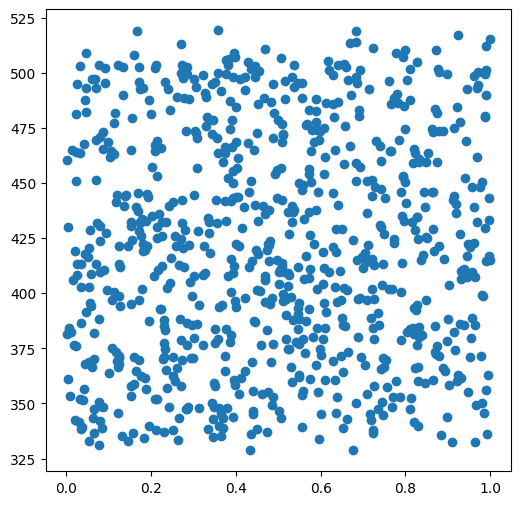

In [23]:
d = 5 # Dimension de l'espace des covariables
n = 1_000 # Taille de l'échantillon
s = 2 # niveau de sparsité

X_train, X_test, y_train, y_test = generate_model_1(d,n)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(X_train[:,0],y_train,'o')
plt.show()

#### \'Etude sur l'impact de la direction

##### Cas STIT

On commence par justifier notre approximation isotrope : on peut l'approcher aussi avec plein de directions, mais c'est très long. 

In [ ]:
# Cas avec énormément de directions

d = 5 # Dimension de l'espace des covariables
n = 1_000 # Taille de l'échantillon

def cross_validation_STIT_discrete_lot_directions(d,n) :

    mean_mean_r2 = []
    mean_mean_errors = []
    mean_variance_errors = []

    for _ in range(10) : 
        X_train, X_test, y_train, y_test = generate_model_1(d,n)

        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        n_directions = 500
        for lifetime in [3, 10, 20, 50, 100] : 
            errors = []
            r2 = []

            # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
            for _ in range(10) : 
                directions = random_direction(n_directions, d)
                forest = SimpleSTITForest_discrete(directions = directions, n_estimators = 50, 
                                                    lifetime = lifetime*d)
                forest.fit(X_train, y_train)
                y_pred, y_std = forest.predict(X_test)
                errors.append(root_mean_squared_error(y_test, y_pred))
                r2.append(r2_score(y_test, y_pred))
            
            mean_r2.append((n_directions, lifetime, sum(r2)/10))
            print((n_directions, lifetime, sum(r2)/10))
            mean_errors.append((n_directions, lifetime, sum(errors)/10))
            print((n_directions, lifetime, sum(errors)/10))
            variance_errors.append((n_directions, lifetime, statistics.variance(errors)))
            print((n_directions, lifetime, statistics.variance(errors)))
        
        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)
    
    return(mean_mean_r2, mean_mean_errors, mean_variance_errors)

(500, 3, 0.9639867009285925)
(500, 3, 9.670369613321098)
(500, 3, 0.23610096944090952)
(500, 10, 0.9644641115562556)
(500, 10, 9.594274340204079)
(500, 10, 0.48436219887536713)
(500, 20, 0.961657164381313)
(500, 20, 9.984025684967843)
(500, 20, 0.12293714841158733)
(500, 100, 0.9607626612513649)
(500, 100, 10.075704512913651)
(500, 100, 0.6662587248363239)
(500, 1000, 0.9649200259348003)
(500, 1000, 9.536806509495019)
(500, 1000, 0.3875342123615481)


([(500, 3, 0.9639867009285925),
  (500, 10, 0.9644641115562556),
  (500, 20, 0.961657164381313),
  (500, 100, 0.9607626612513649),
  (500, 1000, 0.9649200259348003)],
 [(500, 3, 9.670369613321098),
  (500, 10, 9.594274340204079),
  (500, 20, 9.984025684967843),
  (500, 100, 10.075704512913651),
  (500, 1000, 9.536806509495019)],
 [(500, 3, 0.23610096944090952),
  (500, 10, 0.48436219887536713),
  (500, 20, 0.12293714841158733),
  (500, 100, 0.6662587248363239),
  (500, 1000, 0.3875342123615481)])

C'est pour voir les performances du discret dans le cas 500 directions , mais après une exécution (et pas 10) j'ai trouvé que c'est 0.96 le r2, pour tous les lifetime ; mais le meilleur (en terme de variance) ça a l'air d'être 20

In [25]:
list_lot_directions = [mean_r2, mean_errors, variance_errors]

In [ ]:
# Cas avec notre approximation isotrope

d = 5 # Dimension de l'espace des covariables
n = 1_000 # Taille de l'échantillon

X_train, X_test, y_train, y_test = generate_model_1(d,n)

mean_r2 = []
mean_errors = []
variance_errors = []

# Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
n_directions = 500
for lifetime in [3, 10, 20, 100, 500] : 
    errors = []
    r2 = []

    # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
    for _ in range(10) : 
        forest = SimpleSTITForest(n_estimators = 50, 
                                            lifetime = lifetime*d)
        forest.fit(X_train, y_train)
        y_pred, y_std = forest.predict(X_test)
        errors.append(root_mean_squared_error(y_test, y_pred))
        r2.append(r2_score(y_test, y_pred))
    
    mean_r2.append((lifetime, sum(r2)/10))
    print((lifetime, sum(r2)/10))
    mean_errors.append((lifetime, sum(errors)/10))
    print((lifetime, sum(errors)/10))
    variance_errors.append((lifetime, statistics.variance(errors)))
    print((lifetime, statistics.variance(errors)))

mean_r2, mean_errors, variance_errors

(3, 0.522633978998787)
(3, 36.442938329951474)
(3, 1.2634932997716823)
(10, 0.8977550637410779)
(10, 16.86831233372151)
(10, 0.1787726421358502)
(20, 0.938040633540923)
(20, 13.129382764715299)
(20, 0.16117991614643773)
(100, 0.9378123108516823)
(100, 13.156783397415023)
(100, 0.06729832447273384)
(1000, 0.9386110356967714)
(1000, 13.070999176535533)
(1000, 0.09605596869736589)


([(3, 0.522633978998787),
  (10, 0.8977550637410779),
  (20, 0.938040633540923),
  (100, 0.9378123108516823),
  (1000, 0.9386110356967714)],
 [(3, 36.442938329951474),
  (10, 16.86831233372151),
  (20, 13.129382764715299),
  (100, 13.156783397415023),
  (1000, 13.070999176535533)],
 [(3, 1.2634932997716823),
  (10, 0.1787726421358502),
  (20, 0.16117991614643773),
  (100, 0.06729832447273384),
  (1000, 0.09605596869736589)])

In [119]:
# Cas avec notre approximation isotrope

d = 5 # Dimension de l'espace des covariables
n = 1_000 # Taille de l'échantillon

def cross_validation_STIT_isotropy(d,n) :

    mean_mean_r2 = []
    mean_mean_errors = []
    mean_variance_errors = []

    for _ in range(10) :

        X_train, X_test, y_train, y_test = generate_model_1(d,n)

        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le temps de vie)
        for lifetime in [2_000, 5_000, 10_000, 50_000, 70_000, 100_000, 120_000] : 
            errors = []
            r2 = []

            for _ in range(10) : 
                forest = SimpleSTITForest(n_estimators = 50, 
                                                    lifetime = lifetime)
                forest.fit(X_train, y_train)
                y_pred, y_std = forest.predict(X_test)
                errors.append(root_mean_squared_error(y_test, y_pred))
                r2.append(r2_score(y_test, y_pred))
            
            mean_r2.append((lifetime, sum(r2)/10))
            print((lifetime, sum(r2)/10))
            mean_errors.append((lifetime, sum(errors)/10))
            print((lifetime, sum(errors)/10))
            variance_errors.append((lifetime, statistics.variance(errors)))
            print((lifetime, statistics.variance(errors)))

        mean_mean_r2.append(mean_r2) 
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    return(mean_mean_r2, mean_mean_errors, mean_variance_errors)

Performances de l'isotropes un peu comparables ; un peu en-dessous car un r2 de 0.93, et le meilleur en terme de variance c'est lifetime = 100_000.

In [120]:
d = 5 # Dimension de l'espace des covariables
n = 1_000 # Taille de l'échantillon

r2_stit_isotropy, errors_stit_isotropy, variance_stit_isotropy = cross_validation_STIT_isotropy(d,n)

(2000, 0.9444326587375695)
(2000, 12.506078697286481)
(2000, 0.06373615552428986)
(5000, 0.9432404625069125)
(5000, 12.636358085520085)
(5000, 0.1540599383425026)
(10000, 0.9407725385807391)
(10000, 12.910471369408778)
(10000, 0.09421238988395875)
(50000, 0.9439412904984158)
(50000, 12.56240102201119)
(50000, 0.03219880441014507)
(70000, 0.9440839598090001)
(70000, 12.54197341296312)
(70000, 0.1556570999017959)
(100000, 0.9421114065316087)
(100000, 12.764107113239715)
(100000, 0.08091077267248299)
(120000, 0.9425926649317364)
(120000, 12.708868694228675)
(120000, 0.13871238978776335)
(2000, 0.9408875967991708)
(2000, 12.813203222434288)
(2000, 0.1082716188293163)
(5000, 0.9433934884280306)
(5000, 12.539621227341755)
(5000, 0.07728046077228559)
(10000, 0.9413910207133587)
(10000, 12.756833281545248)
(10000, 0.15532406680963257)
(50000, 0.9433649773938815)
(50000, 12.540712293286749)
(50000, 0.13491263040162194)
(70000, 0.9426454070259391)
(70000, 12.617727579551817)
(70000, 0.2039448822

In [121]:
np.save('R2 STIT isotropy.np', r2_stit_isotropy)
np.save('Errors STIT isotropy.np', errors_stit_isotropy)
np.save('Variance STIT isotropy.np', variance_stit_isotropy)

In [33]:
r2, errors, variance

([[(2000, 0.9445774429152399),
   (5000, 0.9405291479361114),
   (10000, 0.9415971270838182),
   (50000, 0.940393659990584),
   (70000, 0.9424344658090108),
   (100000, 0.9424934710173238),
   (120000, 0.9403048882141023)],
  [(2000, 0.9437696603881441),
   (5000, 0.9447284631492472),
   (10000, 0.9446038770094557),
   (50000, 0.9449874891974301),
   (70000, 0.9451769403944141),
   (100000, 0.9437603629698819),
   (120000, 0.943904874620116)],
  [(2000, 0.9452125576542476),
   (5000, 0.945656241086653),
   (10000, 0.9446078206199143),
   (50000, 0.9427004928831929),
   (70000, 0.9445929795497519),
   (100000, 0.9438302314753267),
   (120000, 0.9438777331506246)],
  [(2000, 0.9419347938339859),
   (5000, 0.9416516301337454),
   (10000, 0.9414672855633451),
   (50000, 0.9438488984478486),
   (70000, 0.9432787030431076),
   (100000, 0.9425267156853699),
   (120000, 0.943840852972445)],
  [(2000, 0.942668940220473),
   (5000, 0.9438204805492039),
   (10000, 0.942256320040339),
   (50000, 0

On regarde ensuite si, pour des directions données, faire varier les poids peut avoir un intérêt quelconque

On regarde quelle est l'influence du nombre de directions. 

In [35]:
d = 5 # Dimension de l'espace des covariables
n = 1_000 # Taille de l'échantillon
s = 2 # niveau de sparsité

def cross_validation_STIT_1(d,n): 
    mean_mean_errors = []
    mean_variance_errors = []
    mean_mean_r2 = []
    # Boucle de validation croisée : à chaque boucle correspond un modèle (sinon on surapprend sur l'ensemble test)
    for _ in range(10) : 

        X_train, X_test, y_train, y_test = generate_model_1(d,n)

        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        for n_directions in [10, 20, 50, 100, 200] :
            for lifetime in [3, 10, 20, 100, 500] : 
                errors = []
                r2 = []

                # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
                for _ in range(10) : 
                    directions = random_direction(n_directions, d)
                    forest = SimpleSTITForest_discrete(directions = directions, n_estimators = 50, 
                                                       lifetime = lifetime*d)
                    forest.fit(X_train, y_train)
                    y_pred, y_std = forest.predict(X_test)
                    errors.append(root_mean_squared_error(y_test, y_pred))
                    r2.append(r2_score(y_test, y_pred))
                
                mean_r2.append((n_directions, lifetime, sum(r2)/10))
                print((n_directions, lifetime, sum(r2)/10))
                mean_errors.append((n_directions, lifetime, sum(errors)/10))
                print((n_directions, lifetime, sum(errors)/10))
                variance_errors.append((n_directions, lifetime, statistics.variance(errors)))
                print((n_directions, lifetime, statistics.variance(errors)))

        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    return(mean_mean_r2, mean_mean_errors, mean_variance_errors)

In [36]:
r2_stit_directions, errors_stit_directions, variance_stit_directions = cross_validation_STIT_1(d,n)

(10, 3, 0.884873696089301)
(10, 3, 17.229326525527206)
(10, 3, 24.576340718122538)
(10, 10, 0.9562331581721468)
(10, 10, 10.909857524817921)
(10, 10, 2.4835733989037863)
(10, 20, 0.9033104879332742)
(10, 20, 14.608216098844599)
(10, 20, 60.54170258324509)
(10, 100, 0.9137323847343879)
(10, 100, 14.504351264346464)
(10, 100, 31.81827309103773)
(10, 500, 0.8896454161942693)
(10, 500, 16.388262522965874)
(10, 500, 41.30305026932906)
(20, 3, 0.9456273043890177)
(20, 3, 11.950322713977778)
(20, 3, 8.70502576734724)
(20, 10, 0.9469963279826932)
(20, 10, 12.05861740673213)
(20, 10, 1.6016355901834598)
(20, 20, 0.9497947668006169)
(20, 20, 11.612982593903407)
(20, 20, 4.707799517951843)
(20, 100, 0.9383637811958891)
(20, 100, 12.63532177317524)
(20, 100, 12.352959149501304)
(20, 500, 0.9505998026907502)
(20, 500, 11.609837442671289)
(20, 500, 2.3107001946169947)
(50, 3, 0.9564815801031579)
(50, 3, 10.864083674040117)
(50, 3, 2.826240615671774)
(50, 10, 0.9580457755491445)
(50, 10, 10.688596694

In [104]:
np.save('R2 STIT directions.np', r2_stit_directions)
np.save('Errors STIT directions.np', errors_stit_directions)
np.save('Variance STIT directions.np', variance_stit_directions)

Plus on fait grandir les directions, plus on a de bonnes performances : le meilleur c'est l'isotrope.

#### Cas d'hyperplans de Poisson

In [122]:
d = 5 # Dimension de l'espace des covariables
n = 1_000 # Taille de l'échantillon

def cross_validation_hyperplane_lots_of_direction(d,n): 
    mean_mean_errors = []
    mean_variance_errors = []
    mean_mean_r2 = []
    # Boucle de validation croisée : à chaque boucle correspond un modèle (sinon on surapprend sur l'ensemble test)
    for _ in range(3) : 

        X_train, X_test, y_train, y_test = generate_model_1(d,n)

        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        for n_directions in [10, 50, 200] :
            for lifetime in [5, 10, 15] : 
                errors = []
                r2 = []

                # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
                for _ in range(5) : 
                    directions = random_direction(n_directions, d)
                    forest = SimplePoissonForest_discrete(directions = directions, n_estimators = 50, 
                                                       lifetime = lifetime)
                    forest.fit(X_train, y_train)
                    y_pred, y_std = forest.predict(X_test)
                    errors.append(root_mean_squared_error(y_test, y_pred))
                    r2.append(r2_score(y_test, y_pred))
                
                mean_r2.append((n_directions, lifetime, sum(r2)/5))
                print((n_directions, lifetime, sum(r2)/5))
                mean_errors.append((n_directions, lifetime, sum(errors)/5))
                print((n_directions, lifetime, sum(errors)/5))
                variance_errors.append((n_directions, lifetime, statistics.variance(errors)))
                print((n_directions, lifetime, statistics.variance(errors)))

        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    return(mean_mean_r2, mean_mean_errors, mean_variance_errors)

In [123]:
r2_hyp_directions, errors_hyp_directions, variance_hyp_directions = cross_validation_hyperplane_lots_of_direction(d,n)

(10, 5, 0.6560782736297796)
(10, 5, 29.81831148799393)
(10, 5, 1.1954760236373616)
(10, 10, 0.8112475334351359)
(10, 10, 22.082078232046292)
(10, 10, 1.1043020229755331)
(10, 15, 0.8069542743346835)
(10, 15, 22.34778343202925)
(10, 15, 0.2367296765575477)
(50, 5, 0.637016738309917)
(50, 5, 30.623709733261837)
(50, 5, 2.01096277213671)
(50, 10, 0.8080300925133515)
(50, 10, 22.264914063214036)
(50, 10, 1.3776675365785196)
(50, 15, 0.8009988405588608)
(50, 15, 22.68699933464372)
(50, 15, 0.4073185840519131)
(200, 5, 0.6361070544490012)
(200, 5, 30.614244730913942)
(200, 5, 5.67837346279264)
(200, 10, 0.7958328522173728)
(200, 10, 22.976316127827108)
(200, 10, 0.6056861028362408)
(200, 15, 0.7974344835692884)
(200, 15, 22.895040676278093)
(200, 15, 0.08456914339688905)
(10, 5, 0.6413126247896319)
(10, 5, 30.451048151699883)
(10, 5, 3.8342682283162066)
(10, 10, 0.8119744278878158)
(10, 10, 22.075952381729074)
(10, 10, 0.4219461347726959)
(10, 15, 0.8201445424174022)
(10, 15, 21.592497367583

In [124]:
np.save('R2 Hyp directions.np', r2_hyp_directions)
np.save('Errors Hyp directions.np', errors_hyp_directions)
np.save('Variance Hyp directions.np', variance_hyp_directions)

In [125]:
d = 5 # Dimension de l'espace des covariables
n = 1_000 # Taille de l'échantillon

def cross_validation_hyperplane_isotropy(d,n): 
    mean_mean_errors = []
    mean_variance_errors = []
    mean_mean_r2 = []
    # Boucle de validation croisée : à chaque boucle correspond un modèle (sinon on surapprend sur l'ensemble test)
    for _ in range(5) : 

        X_train, X_test, y_train, y_test = generate_model_1(d,n)

        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        for lifetime in [5, 10, 15] : 
            errors = []
            r2 = []

            # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
            for _ in range(3) : 
                forest = SimplePoissonForest(n_estimators = 50, 
                                                    lifetime = lifetime)
                forest.fit(X_train, y_train)
                y_pred, y_std = forest.predict(X_test)
                errors.append(root_mean_squared_error(y_test, y_pred))
                r2.append(r2_score(y_test, y_pred))
            
            mean_r2.append((n_directions, lifetime, sum(r2)/3))
            print((n_directions, lifetime, sum(r2)/3))
            mean_errors.append((n_directions, lifetime, sum(errors)/3))
            print((n_directions, lifetime, sum(errors)/3))
            variance_errors.append((n_directions, lifetime, statistics.variance(errors)))
            print((n_directions, lifetime, statistics.variance(errors)))

        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    return(mean_mean_r2, mean_mean_errors, mean_variance_errors)

In [126]:
r2_hyp_isotropy, errors_hyp_isotropy, variance_hyp_isotropy = cross_validation_hyperplane_isotropy(d,n)

(2, 5, 0.5877235047287449)
(2, 5, 33.74483733820507)
(2, 5, 7.572709557295304)
(2, 10, 0.7833768951599098)
(2, 10, 24.50935730454459)
(2, 10, 0.3905893125595865)
(2, 15, 0.7923452665916629)
(2, 15, 24.000748937366467)
(2, 15, 0.07865623517877847)
(2, 5, 0.6318464524270059)
(2, 5, 32.2797266460009)
(2, 5, 0.2375879632785111)
(2, 10, 0.7918183853601845)
(2, 10, 24.260770395644723)
(2, 10, 1.0779248480056394)
(2, 15, 0.8015909684723009)
(2, 15, 23.692547417644878)
(2, 15, 0.45503927624031293)
(2, 5, 0.6549656762634681)
(2, 5, 32.413502830852806)
(2, 5, 4.652886450359451)
(2, 10, 0.819507956206886)
(2, 10, 23.47358977111544)
(2, 10, 0.3217050736871412)
(2, 15, 0.8194066778379506)
(2, 15, 23.44725217009606)
(2, 15, 2.6393359010291353)
(2, 5, 0.5916719597607291)
(2, 5, 34.68313632565932)
(2, 5, 11.223959525580934)
(2, 10, 0.7979906234638383)
(2, 10, 24.456951334006092)
(2, 10, 1.0077544466615933)
(2, 15, 0.8036482878410687)
(2, 15, 24.118396499464243)
(2, 15, 0.5194487517472982)
(2, 5, 0.632

In [127]:
np.save('R2 Hyp isotropy.np', r2_hyp_isotropy)
np.save('Errors Hyp isotropy.np', errors_hyp_isotropy)
np.save('Variance Hyp isotropy.np', variance_hyp_isotropy)

#### Cas de Poisson-Voronoï et ses dérivés

In [101]:
d = 5 # Dimension de l'espace des covariables
n = 1_000 # Taille de l'échantillon

def cross_validation_voronoi(d,n): 
    mean_mean_errors = []
    mean_variance_errors = []
    mean_mean_r2 = []
    # Boucle de validation croisée : à chaque boucle correspond un modèle (sinon on surapprend sur l'ensemble test)
    for _ in range(10) : 

        X_train, X_test, y_train, y_test = generate_model_1(d,n)

        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        for metric in [1,2, np.inf] : 
            for lifetime in [70, 100, 120, 200] : 
                errors = []
                r2 = []

                # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
                for _ in range(10) : 
                    forest = VoronoiForestRegressor(n_estimators = 50, 
                                                        lifetime = lifetime, ord = metric)
                    forest.fit(X_train, y_train)
                    y_pred = forest.predict(X_test)
                    errors.append(root_mean_squared_error(y_test, y_pred))
                    r2.append(r2_score(y_test, y_pred))
                
                mean_r2.append((lifetime, metric, sum(r2)/10))
                print((lifetime, metric, sum(r2)/10))
                mean_errors.append((lifetime, metric, sum(errors)/10))
                print((lifetime, metric, sum(errors)/10))
                variance_errors.append((lifetime, metric, statistics.variance(errors)))
                print((lifetime, metric, statistics.variance(errors)))

            mean_mean_r2.append(mean_r2)
            mean_mean_errors.append(mean_errors)
            mean_variance_errors.append(variance_errors)

    return(mean_mean_r2, mean_mean_errors, mean_variance_errors)

In [102]:
r2_voronoi, errors_voronoi, variance_voronoi = cross_validation_voronoi(d,n)

(70, 1, 0.915574310330047)
(70, 1, 15.290999368231331)
(70, 1, 0.22903407645220789)
(100, 1, 0.927780507872033)
(100, 1, 14.143476195685716)
(100, 1, 0.1648196013212625)
(120, 1, 0.927872210403418)
(120, 1, 14.129902808912325)
(120, 1, 0.3087906383166119)
(200, 1, 0.8021957118722087)
(200, 1, 23.394354785534453)
(200, 1, 1.1119291121942354)
(70, 2, 0.9247162114598488)
(70, 2, 14.442620351772268)
(70, 2, 0.10104614875553876)
(100, 2, 0.9323419889410853)
(100, 2, 13.688501381896662)
(100, 2, 0.18572332810109143)
(120, 2, 0.9287194619213096)
(120, 2, 14.036468591762548)
(120, 2, 0.6234507543427814)
(200, 2, 0.8145813760556055)
(200, 2, 22.61188218360119)
(200, 2, 2.963726838899027)
(70, inf, 0.9067450644013118)
(70, inf, 16.074308027071908)
(70, inf, 0.12369834007118048)
(100, inf, 0.9175852906807208)
(100, inf, 15.104286228501262)
(100, inf, 0.34118256291912724)
(120, inf, 0.9175400507125552)
(120, inf, 15.111006534440467)
(120, inf, 0.2548995760095593)
(200, inf, 0.8123240191289163)
(20

In [106]:
np.save('R2 Voronoi.np', r2_voronoi)
np.save('Errors Voronoi.np', errors_voronoi)
np.save('Variance Voronoi.np', variance_voronoi)

#### Poisson-Delaunay

In [116]:
d = 5 # Dimension de l'espace des covariables
n = 1_000 # Taille de l'échantillon

def cross_validation_delaunay(d,n): 
    mean_mean_errors = []
    mean_variance_errors = []
    mean_mean_r2 = []
    # Boucle de validation croisée : à chaque boucle correspond un modèle (sinon on surapprend sur l'ensemble test)
    for _ in range(5) : 

        X_train, X_test, y_train, y_test = generate_model_1(d,n)
        y_train = np.array(y_train).ravel()

        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        for padding in [0.5, 1, 2, 3] :
            for lifetime in [10, 20, 50, 70] : 
                errors = []
                r2 = []

                # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
                for _ in range(5) : 
                    forest = DelaunayForestRegressor(n_estimators = 50, 
                                                        lifetime = lifetime, padding = padding)
                    forest.fit(X_train, y_train)
                    y_pred = forest.predict(X_test)
                    errors.append(root_mean_squared_error(y_test, y_pred))
                    r2.append(r2_score(y_test, y_pred))
                
                mean_r2.append((n_directions, lifetime, padding, sum(r2)/5))
                print((n_directions, lifetime, padding, sum(r2)/5))
                mean_errors.append((n_directions, lifetime, padding,  sum(errors)/5))
                print((n_directions, lifetime, padding, sum(errors)/5))
                variance_errors.append((n_directions, lifetime, padding, statistics.variance(errors)))
                print((n_directions, lifetime, padding, statistics.variance(errors)))

        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    return(mean_mean_r2, mean_mean_errors, mean_variance_errors)

In [117]:
r2_delaunay, errors_delaunay, variance_delaunay = cross_validation_delaunay(d,n)

(2, 10, 0.5, 0.10293971067668414)
(2, 10, 0.5, 50.51243278759778)
(2, 10, 0.5, 0.020994823345969058)
(2, 20, 0.5, 0.3908118345247358)
(2, 20, 0.5, 41.620031759955666)
(2, 20, 0.5, 0.62052215257396)
(2, 50, 0.5, 0.7170412042918188)
(2, 50, 0.5, 28.36786867160017)
(2, 50, 0.5, 0.11021404639488408)
(2, 70, 0.5, 0.6990201095311722)
(2, 70, 0.5, 29.25735976337569)
(2, 70, 0.5, 0.11090823193798928)
(2, 10, 1, 0.22888502753342074)
(2, 10, 1, 46.82494838534625)
(2, 10, 1, 0.8982862554270611)
(2, 20, 1, 0.6474832601393679)
(2, 20, 1, 31.65799815815227)
(2, 20, 1, 0.5500615262628595)
(2, 50, 1, 0.8275810459295385)
(2, 50, 1, 22.142991702048757)
(2, 50, 1, 0.12731998401618896)
(2, 70, 1, 0.8303960212701217)
(2, 70, 1, 21.953279866539184)
(2, 70, 1, 0.5759525725447187)
(2, 10, 2, 0.2767516557005115)
(2, 10, 2, 45.34864136887193)
(2, 10, 2, 0.8091805489970483)
(2, 20, 2, 0.6342798102638364)
(2, 20, 2, 32.25004648257692)
(2, 20, 2, 0.19772276038054556)
(2, 50, 2, 0.7537661320217942)
(2, 50, 2, 26.45

In [118]:
np.save('R2 Delaunay.np', r2_delaunay)
np.save('Errors Delaunay.np', errors_delaunay)
np.save('Variance Delaunay.np', variance_delaunay)

#### Comparaison entre les meilleurs modèles sur la sparsitité

### Avec les vraies données

#### Cas STIT

In [190]:
# Cas STIT discret

def bio_cross_validation_STIT_discrete_lot_directions(number_split) :

    X, y = load_diabetes(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    mean_mean_r2 = []
    mean_mean_errors = []
    mean_variance_errors = []

    liste_X_train = np.array_split(X_train, number_split)
    liste_y_train = np.array_split(y_train, number_split)

    for i in range(number_split) :
        
        indices = [m for m in range(number_split) if m!=i]
        print(indices)

        X_train_test = np.array(liste_X_train[i])
        y_train_test = np.array(liste_y_train[i])
        X_train_train = []
        y_train_train = []
        for m in indices :
            for l in liste_X_train[m] :
                X_train_train.append(l)
            for k in liste_y_train[m] :
                y_train_train.append(k)

        X_train_train = np.array(X_train_train)
        y_train_train = np.array(y_train_train)
        
        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        
        liste_n_dir = [10, 20, 50, 100, 200]
        liste_lifetime = [3, 10, 20, 50, 100]
        for n_directions in liste_n_dir :
            for lifetime in liste_lifetime : 
                errors = []
                r2 = []

                # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
                for _ in range(10) : 
                    directions = random_direction(n_directions, X.shape[1])
                    forest = SimpleSTITForest_discrete(directions = directions, n_estimators = 50, 
                                                        lifetime = lifetime*X.shape[1])
                    forest.fit(X_train_train, y_train_train)
                    y_train_pred, y_std = forest.predict(X_train_test)
                    errors.append(root_mean_squared_error(y_train_test, y_train_pred))
                    r2.append(r2_score(y_train_test, y_train_pred))
                
                mean_r2.append((n_directions, lifetime, sum(r2)/10))
                print((n_directions, lifetime, sum(r2)/10))
                mean_errors.append((n_directions, lifetime, sum(errors)/10))
                print((n_directions, lifetime, sum(errors)/10))
                variance_errors.append((n_directions, lifetime, statistics.variance(errors)))
                print((n_directions, lifetime, statistics.variance(errors)))
            
        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    transitoire = []
    
    for t in range(len(liste_lifetime)*len(liste_n_dir)):
        transitoire.append([mean_mean_r2[0][t][:2], statistics.mean([mean_mean_r2[i][t][-1] for i in range(number_split)])])
    
    max_transitoire = np.max([t[-1] for t in transitoire])
    i_max = 0
    for i in range(len(transitoire)) :
        if transitoire[i][1] == max_transitoire :
            i_max = i
    best_n_directions, best_lifetime = transitoire[i_max][0]

    errors_test = []
    r2_test = []

    for _ in range(10) : 
        directions = random_direction(best_n_directions, X.shape[1])
        forest = SimpleSTITForest_discrete(directions = directions, n_estimators = 50, 
                                            lifetime = best_lifetime*X.shape[1])
        forest.fit(X_train, y_train)
        y_pred, y_std = forest.predict(X_test)
        errors_test.append(root_mean_squared_error(y_test, y_pred))
        r2_test.append(r2_score(y_test, y_pred))
    
    r2_best = sum(r2_test)/10
    errors_best = sum(errors_test)/10
    variance_best = statistics.variance(errors_test)
    
    return(mean_mean_r2, mean_mean_errors, mean_variance_errors, 
           best_n_directions, best_lifetime, r2_best, errors_best, variance_best)

In [191]:
bio_r2_stit_directions, bio_errors_stit_directions, bio_variance_stit_directions, bio_stit_directions_best_n_directions, bio_stit_directions_best_lifetime, bio_stit_directions_r2_best, bio_stit_directions_errors_best, bio_stit_directions_variance_best = bio_cross_validation_STIT_discrete_lot_directions(4)

[1, 2, 3]
(10, 3, 0.30321981872844345)
(10, 3, 60.978656853977476)
(10, 3, 10.866763666551858)
(10, 10, 0.3818040425713584)
(10, 10, 57.470047843557495)
(10, 10, 5.443626651737539)
(10, 20, 0.3792452250420325)
(10, 20, 57.58391464167455)
(10, 20, 6.099544818808652)
(10, 50, 0.3939868601159962)
(10, 50, 56.88291642358847)
(10, 50, 7.61596362433853)
(10, 100, 0.3785885214308796)
(10, 100, 57.58566154031966)
(10, 100, 9.780160696299555)
(20, 3, 0.3822536399378086)
(20, 3, 57.47057849129499)
(20, 3, 2.7029613829477674)
(20, 10, 0.40471049471856235)
(20, 10, 56.41398295615827)
(20, 10, 2.8949246780045748)
(20, 20, 0.3887389247954799)
(20, 20, 57.12793314793661)
(20, 20, 7.776988230203291)
(20, 50, 0.39603805136377934)
(20, 50, 56.810611811428316)
(20, 50, 4.555416721560339)
(20, 100, 0.43431441152936695)
(20, 100, 55.01020224186885)
(20, 100, 0.691655286806072)
(50, 3, 0.42941837158000407)
(50, 3, 55.24725266262267)
(50, 3, 0.7583967922568946)
(50, 10, 0.43221721259235774)
(50, 10, 55.10217

In [192]:
bio_stit_directions_best_n_directions, bio_stit_directions_best_lifetime, bio_stit_directions_r2_best, bio_stit_directions_errors_best, bio_stit_directions_variance_best

(200, 10, 0.30804616379657357, 59.56100532617465, 0.8615825674174463)

In [193]:
np.save('BIO R2 STIT directions.np', bio_r2_stit_directions)
np.save('BIO Errors STIT directions.np', bio_errors_stit_directions)
np.save('BIO Variance STIT directions.np', bio_variance_stit_directions)
np.save('BIO hyperparamètres STIT directions.np', (bio_stit_directions_best_n_directions, bio_stit_directions_best_lifetime))
np.save('BIO best results STIT directions.np', (bio_stit_directions_r2_best, bio_stit_directions_errors_best, bio_stit_directions_variance_best))

In [ ]:
# Cas STIT isotrope

def bio_cross_validation_STIT_isotropy(number_split) :

    X, y = load_diabetes(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    mean_mean_r2 = []
    mean_mean_errors = []
    mean_variance_errors = []

    liste_X_train = np.array_split(X_train, number_split)
    liste_y_train = np.array_split(y_train, number_split)

    for i in range(number_split) :
        
        indices = [m for m in range(number_split) if m!=i]
        print(indices)

        X_train_test = np.array(liste_X_train[i])
        y_train_test = np.array(liste_y_train[i])
        X_train_train = []
        y_train_train = []
        for m in indices :
            for l in liste_X_train[m] :
                X_train_train.append(l)
            for k in liste_y_train[m] :
                y_train_train.append(k)

        X_train_train = np.array(X_train_train)
        y_train_train = np.array(y_train_train)
        
        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        liste_lifetime = [2_000, 5_000, 10_000, 50_000, 70_000, 100_000, 120_000]
        for lifetime in liste_lifetime : 
            errors = []
            r2 = []

            # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
            for _ in range(10) : 
                forest = SimpleSTITForest(n_estimators = 50, 
                                                    lifetime = lifetime)
                forest.fit(X_train_train, y_train_train)
                y_train_pred, y_std = forest.predict(X_train_test)
                errors.append(root_mean_squared_error(y_train_test, y_train_pred))
                r2.append(r2_score(y_train_test, y_train_pred))
            
            mean_r2.append((lifetime, sum(r2)/10))
            print((lifetime, sum(r2)/10))
            mean_errors.append((lifetime, sum(errors)/10))
            print((lifetime, sum(errors)/10))
            variance_errors.append((lifetime, statistics.variance(errors)))
            print((lifetime, statistics.variance(errors)))
            
        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    transitoire = []
    
    for t in range(len(liste_lifetime)):
        transitoire.append([mean_mean_r2[0][t][0], statistics.mean([mean_mean_r2[i][t][-1] for i in range(number_split)])])
    
    max_transitoire = np.max([t[-1] for t in transitoire])
    i_max = 0
    for i in range(len(transitoire)) :
        if transitoire[i][1] == max_transitoire :
            i_max = i
    best_lifetime = transitoire[i_max][0]
    
    forest = SimpleSTITForest(n_estimators = 50, 
                                        lifetime = best_lifetime)
    forest.fit(X_train, y_train)
    y_pred, y_std = forest.predict(X_test)
    r2_best = r2_score(y_test, y_pred)
    errors_best = root_mean_squared_error(y_test, y_pred)
    
    return(mean_mean_r2, mean_mean_errors, mean_variance_errors, 
           best_lifetime, r2_best, errors_best)

In [196]:
bio_r2_stit_isotropy, bio_errors_stit_isotropy, bio_variance_stit_isotropy, bio_stit_isotropy_best_lifetime, bio_stit_isotropy_r2_best, bio_stit_isotropy_errors_best= bio_cross_validation_STIT_isotropy(4)

[1, 2, 3]
[[ 0.04897352  0.05068012  0.05846277 ...  0.03430886  0.02200407
   0.02791705]
 [ 0.00175052  0.05068012  0.05954058 ...  0.1081111   0.06898589
   0.12732762]
 [-0.00914709  0.05068012  0.17055523 ...  0.03430886  0.03365381
   0.03205916]
 ...
 [ 0.05987114 -0.04464164 -0.02129532 ...  0.07120998  0.07912244
   0.13561183]
 [-0.07816532 -0.04464164 -0.0730303  ... -0.03949338 -0.01811369
  -0.08391984]
 [ 0.04170844  0.05068012  0.07139652 ...  0.03430886  0.07340696
   0.08590655]]
(2000, 0.41928238153696196)
(2000, 55.73902256283642)
(2000, 0.3736139114624456)
(5000, 0.4190839740111555)
(5000, 55.75062567733247)
(5000, 0.11580033423225364)
(10000, 0.4201810405422447)
(10000, 55.69540197361117)
(10000, 0.43193634861218955)
(50000, 0.42152882774513384)
(50000, 55.62835637308274)
(50000, 0.7123004958217884)
(70000, 0.41588452502136225)
(70000, 55.90310313254899)
(70000, 0.22049456314195728)
(100000, 0.41388929825703347)
(100000, 55.99596044108519)
(100000, 0.53712842305432

In [197]:
bio_stit_isotropy_best_lifetime, bio_stit_isotropy_r2_best, bio_stit_isotropy_errors_best

(70000, 0.34628075631886224, 57.89839876301892)

In [198]:
np.save('BIO R2 STIT isotropy.np', bio_r2_stit_isotropy)
np.save('BIO Errors STIT isotropy.np', bio_errors_stit_isotropy)
np.save('BIO Variance STIT isotropy.np', bio_variance_stit_isotropy)
np.save('BIO hyperparamètres STIT isotropy.np', bio_stit_isotropy_best_lifetime)
np.save('BIO best results STIT isotropy.np', (bio_stit_isotropy_r2_best, bio_stit_isotropy_errors_best))

#### Cas d'hyperplans de Poisson

In [308]:
# Cas hyp discret

def bio_cross_validation_hyp_discrete_lot_directions(number_split) :

    X, y = load_diabetes(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    mean_mean_r2 = []
    mean_mean_errors = []
    mean_variance_errors = []

    liste_X_train = np.array_split(X_train, number_split)
    liste_y_train = np.array_split(y_train, number_split)

    for i in range(number_split) :
        
        indices = [m for m in range(number_split) if m!=i]
        print(indices)

        X_train_test = np.array(liste_X_train[i])
        y_train_test = np.array(liste_y_train[i])
        X_train_train = []
        y_train_train = []
        for m in indices :
            for l in liste_X_train[m] :
                X_train_train.append(l)
            for k in liste_y_train[m] :
                y_train_train.append(k)

        X_train_train = np.array(X_train_train)
        y_train_train = np.array(y_train_train)
        
        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        
        liste_n_dir = [10, 50, 200]
        liste_lifetime = [5, 10, 15]
        for n_directions in liste_n_dir :
            for lifetime in liste_lifetime : 
                errors = []
                r2 = []

                # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
                for _ in range(10) : 
                    directions_a = random_direction(n_directions, X.shape[1])
                    forest = SimplePoissonForest_discrete(directions = directions_a, n_estimators = 50, 
                                                        lifetime = lifetime)
                    #print(directions, X_train_train.shape)
                    forest.fit(X_train_train, y_train_train)
                    y_train_pred, y_std = forest.predict(X_train_test)
                    errors.append(root_mean_squared_error(y_train_test, y_train_pred))
                    r2.append(r2_score(y_train_test, y_train_pred))
                
                mean_r2.append((n_directions, lifetime, sum(r2)/10))
                print((n_directions, lifetime, sum(r2)/10))
                mean_errors.append((n_directions, lifetime, sum(errors)/10))
                print((n_directions, lifetime, sum(errors)/10))
                variance_errors.append((n_directions, lifetime, statistics.variance(errors)))
                print((n_directions, lifetime, statistics.variance(errors)))
            
        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    transitoire = []
    
    for t in range(len(liste_lifetime)*len(liste_n_dir)):
        transitoire.append([mean_mean_r2[0][t][:2], statistics.mean([mean_mean_r2[i][t][-1] for i in range(number_split)])])
    
    max_transitoire = np.max([t[-1] for t in transitoire])
    i_max = 0
    for i in range(len(transitoire)) :
        if transitoire[i][1] == max_transitoire :
            i_max = i
    best_n_directions, best_lifetime = transitoire[i_max][0]

    errors_test = []
    r2_test = []

    for _ in range(10) : 
        directions = random_direction(best_n_directions, X.shape[1])
        forest = SimplePoissonForest_discrete(directions = directions, n_estimators = 50, 
                                            lifetime = best_lifetime)
        forest.fit(X_train, y_train)
        y_pred, y_std = forest.predict(X_test)
        errors_test.append(root_mean_squared_error(y_test, y_pred))
        r2_test.append(r2_score(y_test, y_pred))
    
    r2_best = sum(r2_test)/10
    errors_best = sum(errors_test)/10
    variance_best = statistics.variance(errors_test)
    
    return(mean_mean_r2, mean_mean_errors, mean_variance_errors, 
           best_n_directions, best_lifetime, r2_best, errors_best, variance_best)

In [305]:
bio_r2_hyp_discrete, bio_errors_hyp_discrete, bio_variance_hyp_discrete, bio_best_n_directions_hyp_discrete, bio_best_lifetime_hyp_discrete, bio_r2_best_hyp_discrete, bio_errors_best_hyp_discrete, bio_variance_best_hyp_discrete = bio_cross_validation_hyp_discrete_lot_directions(3)

[1, 2]


KeyboardInterrupt: 

In [318]:
# Cas hyp discret

def bio_cross_validation_hyp_discrete_lot_directions(number_split) :

    X, y = load_diabetes(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    mean_mean_r2 = []
    mean_mean_errors = []
    mean_variance_errors = []

    liste_X_train = np.array_split(X_train, number_split)
    liste_y_train = np.array_split(y_train, number_split)

    for i in range(number_split) :
        
        indices = [m for m in range(number_split) if m!=i]
        print(indices)

        X_train_test = np.array(liste_X_train[i])
        y_train_test = np.array(liste_y_train[i])
        X_train_train = []
        y_train_train = []
        for m in indices :
            for l in liste_X_train[m] :
                X_train_train.append(l)
            for k in liste_y_train[m] :
                y_train_train.append(k)

        X_train_train = np.array(X_train_train)
        y_train_train = np.array(y_train_train)
        
        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        
        liste_n_dir = [10, 50, 200]
        liste_lifetime = [30, 50, 70, 100]
        for n_directions in liste_n_dir :
            for lifetime in liste_lifetime : 
                errors = []
                r2 = []

                # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
                for _ in range(10) : 
                    directions_a = random_direction(n_directions, X.shape[1])
                    forest = SimplePoissonForest_discrete(directions = directions_a, n_estimators = 50, 
                                                        lifetime = lifetime)
                    #print(directions, X_train_train.shape)
                    forest.fit(X_train_train, y_train_train)
                    y_train_pred, y_std = forest.predict(X_train_test)
                    errors.append(root_mean_squared_error(y_train_test, y_train_pred))
                    r2.append(r2_score(y_train_test, y_train_pred))
                
                mean_r2.append((n_directions, lifetime, sum(r2)/10))
                print((n_directions, lifetime, sum(r2)/10))
                mean_errors.append((n_directions, lifetime, sum(errors)/10))
                print((n_directions, lifetime, sum(errors)/10))
                variance_errors.append((n_directions, lifetime, statistics.variance(errors)))
                print((n_directions, lifetime, statistics.variance(errors)))
            
        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    transitoire = []
    
    for t in range(len(liste_lifetime)*len(liste_n_dir)):
        transitoire.append([mean_mean_r2[0][t][:2], statistics.mean([mean_mean_r2[i][t][-1] for i in range(number_split)])])
    
    max_transitoire = np.max([t[-1] for t in transitoire])
    i_max = 0
    for i in range(len(transitoire)) :
        if transitoire[i][1] == max_transitoire :
            i_max = i
    best_n_directions, best_lifetime = transitoire[i_max][0]

    errors_test = []
    r2_test = []

    for _ in range(10) : 
        directions = random_direction(best_n_directions, X.shape[1])
        forest = SimplePoissonForest_discrete(directions = directions, n_estimators = 50, 
                                            lifetime = best_lifetime)
        forest.fit(X_train, y_train)
        y_pred, y_std = forest.predict(X_test)
        errors_test.append(root_mean_squared_error(y_test, y_pred))
        r2_test.append(r2_score(y_test, y_pred))
    
    r2_best = sum(r2_test)/10
    errors_best = sum(errors_test)/10
    variance_best = statistics.variance(errors_test)
    
    return(mean_mean_r2, mean_mean_errors, mean_variance_errors, 
           best_n_directions, best_lifetime, r2_best, errors_best, variance_best)

In [319]:
bio_r2_hyp_discrete_2, bio_errors_hyp_discrete_2, bio_variance_hyp_discrete_2, bio_best_n_directions_hyp_discrete_2, bio_best_lifetime_hyp_discrete_2, bio_r2_best_hyp_discrete_2, bio_errors_best_hyp_discrete_2, bio_variance_best_hyp_discrete_2 = bio_cross_validation_hyp_discrete_lot_directions(3)

[1, 2]
(10, 30, 0.18788851937738196)
(10, 30, 64.62953940341691)
(10, 30, 2.2960959972678725)
(10, 50, 0.18702205947304767)
(10, 50, 64.65845052068366)
(10, 50, 3.0970461352910266)
(10, 70, 0.2227077185118583)
(10, 70, 63.18082362118374)
(10, 70, 8.945873472369241)
(10, 100, 0.17755896313842806)
(10, 100, 65.03045378108344)
(10, 100, 3.5986516756950726)
(50, 30, 0.2259088702182605)
(50, 30, 63.10426128969025)
(50, 30, 1.3857361441622489)
(50, 50, 0.24964330299698406)
(50, 50, 62.12053358842796)
(50, 50, 2.5547361873853185)
(50, 70, 0.23672691783153418)
(50, 70, 62.66781052072851)
(50, 70, 0.5243300085390207)
(50, 100, 0.17621595017983216)
(50, 100, 65.1008183453108)
(50, 100, 1.1035173487060284)
(200, 30, 0.2462599014806826)
(200, 30, 62.274219791598966)
(200, 30, 0.6579427936813151)
(200, 50, 0.25640510124885596)
(200, 50, 61.85659248017832)
(200, 50, 0.25154460453771277)
(200, 70, 0.23277031941200949)
(200, 70, 62.82903395958696)
(200, 70, 0.6656899662827487)
(200, 100, 0.16733049994

In [320]:
np.save('BIO R2 hyp discrete.np', bio_r2_hyp_discrete)
np.save('BIO Errors hyp discrete.np', bio_errors_hyp_discrete)
np.save('BIO Variance hyp discrete.np', bio_variance_hyp_discrete)
np.save('BIO hyperparamètres hyp discrete.np', (bio_best_n_directions_hyp_discrete, bio_best_lifetime_hyp_discrete))
np.save('BIO best results hyp discrete.np', (bio_r2_best_hyp_discrete, bio_errors_best_hyp_discrete, bio_variance_best_hyp_discrete))

Et maintenant cas isotrope

In [ ]:
# Cas hyp isotrope

def bio_cross_validation_hyp_isotropy(number_split) :

    X, y = load_diabetes(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    mean_mean_r2 = []
    mean_mean_errors = []
    mean_variance_errors = []

    liste_X_train = np.array_split(X_train, number_split)
    liste_y_train = np.array_split(y_train, number_split)

    for i in range(number_split) :
        
        indices = [m for m in range(number_split) if m!=i]
        print(indices)

        X_train_test = np.array(liste_X_train[i])
        y_train_test = np.array(liste_y_train[i])
        X_train_train = []
        y_train_train = []
        for m in indices :
            for l in liste_X_train[m] :
                X_train_train.append(l)
            for k in liste_y_train[m] :
                y_train_train.append(k)

        X_train_train = np.array(X_train_train)
        y_train_train = np.array(y_train_train)
        
        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        liste_lifetime = [30, 60, 100, 120]
        for lifetime in liste_lifetime : 
            errors = []
            r2 = []

            # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
            for _ in range(4) : 
                forest = SimplePoissonForest(n_estimators = 50, 
                                                    lifetime = lifetime)
                forest.fit(X_train_train, y_train_train)
                y_train_pred, y_std = forest.predict(X_train_test)
                errors.append(root_mean_squared_error(y_train_test, y_train_pred))
                r2.append(r2_score(y_train_test, y_train_pred))
            
            mean_r2.append((lifetime, sum(r2)/4))
            print((lifetime, sum(r2)/4))
            mean_errors.append((lifetime, sum(errors)/4))
            print((lifetime, sum(errors)/4))
            variance_errors.append((lifetime, statistics.variance(errors)))
            print((lifetime, statistics.variance(errors)))
            
        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    transitoire = []
    
    for t in range(len(liste_lifetime)):
        transitoire.append([mean_mean_r2[0][t][0], statistics.mean([mean_mean_r2[i][t][-1] for i in range(number_split)])])
    
    max_transitoire = np.max([t[-1] for t in transitoire])
    i_max = 0
    for i in range(len(transitoire)) :
        if transitoire[i][1] == max_transitoire :
            i_max = i
    best_lifetime = transitoire[i_max][0]
    
    forest = SimplePoissonForest(n_estimators = 50, 
                                        lifetime = best_lifetime)
    forest.fit(X_train, y_train)
    y_pred, y_std = forest.predict(X_test)
    r2_best = r2_score(y_test, y_pred)
    errors_best = root_mean_squared_error(y_test, y_pred)
    
    return(mean_mean_r2, mean_mean_errors, mean_variance_errors, 
           best_lifetime, r2_best, errors_best)

In [220]:
bio_r2_hyp_isotropy, bio_errors_hyp_isotropy, bio_variance_hyp_isotropy, bio_best_lifetime_hyp_isotropy, bio_r2_best_hyp_isotropy, bio_errors_best_hyp_isotropy = bio_cross_validation_hyp_isotropy(3)

[1, 2]
(30, 0.332915823563457)
(30, 61.10615278717802)
(30, 0.5029701329327815)
(60, 0.3756829550670808)
(60, 59.11562493174678)
(60, 0.3619999501926708)
(100, 0.309942878140435)
(100, 62.14733990057063)
(100, 0.8665250745454968)
(120, 0.23842572850408703)
(120, 65.29003404202658)
(120, 0.6752192376910992)
[0, 2]
(30, 0.28825676924076904)
(30, 65.27308048352701)
(30, 1.709522059751407)
(60, 0.3216305374621372)
(60, 63.73292407076451)
(60, 0.17642194673764966)
(100, 0.23970090829458215)
(100, 67.47177729517357)
(100, 0.2196802262474467)
(120, 0.18953320241139993)
(120, 69.66279126350562)
(120, 0.13454371741620316)
[0, 1]
(30, 0.34721674695360816)
(30, 66.62257902022775)
(30, 1.1047498709915027)
(60, 0.3856175837922855)
(60, 64.62844587280385)
(60, 1.8762864564718316)
(100, 0.2838627065396947)
(100, 69.78411356989128)
(100, 0.569635478264101)
(120, 0.22363486311711736)
(120, 72.6604251959324)
(120, 0.4067822087469019)


In [221]:
bio_best_lifetime_hyp_isotropy, bio_r2_best_hyp_isotropy, bio_errors_best_hyp_isotropy

(60, 0.28900943588185735, 60.38135251384141)

In [222]:
np.save('BIO R2 hyp isotropy.np', bio_r2_hyp_isotropy)
np.save('BIO Errors hyp isotropy.np', bio_errors_hyp_isotropy)
np.save('BIO Variance hyp isotropy.np', bio_variance_hyp_isotropy)
np.save('BIO hyperparamètres hyp isotropy.np', bio_best_lifetime_hyp_isotropy)
np.save('BIO best results hyp isotropy.np', (bio_r2_best_hyp_isotropy, bio_errors_best_hyp_isotropy))

#### Cas Voronoi

In [296]:
# Cas Voronoi

def bio_cross_validation_Voronoi(number_split) :

    X, y = load_diabetes(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    mean_mean_r2 = []
    mean_mean_errors = []
    mean_variance_errors = []

    liste_X_train = np.array_split(X_train, number_split)
    liste_y_train = np.array_split(y_train, number_split)

    for i in range(number_split) :
        
        indices = [m for m in range(number_split) if m!=i]
        print(indices)

        X_train_test = np.array(liste_X_train[i])
        y_train_test = np.array(liste_y_train[i])
        X_train_train = []
        y_train_train = []
        for m in indices :
            for l in liste_X_train[m] :
                X_train_train.append(l)
            for k in liste_y_train[m] :
                y_train_train.append(k)

        X_train_train = np.array(X_train_train)
        y_train_train = np.array(y_train_train)
        
        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        
        liste_metric = [1,2, np.inf]
        liste_lifetime = [20, 40, 50, 70, 100, 120]
        for ords in liste_metric :
            for lifetime in liste_lifetime : 
                errors = []
                r2 = []

                # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
                for _ in range(10) : 
                    forest = VoronoiForestRegressor(ord = ords, n_estimators = 50, 
                                                        lifetime = lifetime)
                    forest.fit(X_train_train, y_train_train)
                    y_train_pred = forest.predict(X_train_test)
                    errors.append(root_mean_squared_error(y_train_test, y_train_pred))
                    r2.append(r2_score(y_train_test, y_train_pred))
                
                mean_r2.append((ords, lifetime, sum(r2)/10))
                print((ords, lifetime, sum(r2)/10))
                mean_errors.append((ords, lifetime, sum(errors)/10))
                print((ords, lifetime, sum(errors)/10))
                variance_errors.append((ords, lifetime, statistics.variance(errors)))
                print((ords, lifetime, statistics.variance(errors)))
            
        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    transitoire = []
    
    for t in range(len(liste_lifetime)*len(liste_metric)):
        transitoire.append([mean_mean_r2[0][t][:2], statistics.mean([mean_mean_r2[i][t][-1] for i in range(number_split)])])
    
    max_transitoire = np.max([t[-1] for t in transitoire])
    i_max = 0
    for i in range(len(transitoire)) :
        if transitoire[i][1] == max_transitoire :
            i_max = i
    best_metric, best_lifetime = transitoire[i_max][0]


    forest = VoronoiForestRegressor(ord = best_metric, n_estimators = 50, 
                                        lifetime = best_lifetime)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    
    r2_best = r2_score(y_test, y_pred)
    errors_best = root_mean_squared_error(y_test, y_pred)
    
    return(mean_mean_r2, mean_mean_errors, mean_variance_errors, 
           best_metric, best_lifetime, r2_best, errors_best)

In [297]:
bio_r2_voronoi, bio_errors_voronoi, bio_variance_voronoi, bio_best_metric_voronoi, bio_best_lifetime_voronoi, bio_r2_best_voronoi, bio_errors_best_voronoi = bio_cross_validation_Voronoi(4)

[1, 2, 3]
(1, 20, 0.2548322330514171)
(1, 20, 69.32731498434346)
(1, 20, 0.2312038521186561)
(1, 40, 0.26159070906070647)
(1, 40, 69.01104597333891)
(1, 40, 0.40740651508299497)
(1, 50, 0.24705698877655)
(1, 50, 69.68702397448256)
(1, 50, 0.3947707903974226)
(1, 70, 0.2350092746409282)
(1, 70, 70.24246320697367)
(1, 70, 0.3813221768857787)
(1, 100, 0.21760469274262578)
(1, 100, 71.03466943275517)
(1, 100, 0.7618701541227485)
(1, 120, 0.17834909683711056)
(1, 120, 72.79473491548006)
(1, 120, 0.82571687428108)
(2, 20, 0.2716863884950059)
(2, 20, 68.53522485455264)
(2, 20, 0.7720962986905769)
(2, 40, 0.2660229931857362)
(2, 40, 68.8039057062208)
(2, 40, 0.360612836298706)
(2, 50, 0.26502922647881483)
(2, 50, 68.84383286531384)
(2, 50, 1.3762968347642635)
(2, 70, 0.25480400172695294)
(2, 70, 69.3259914460873)
(2, 70, 0.6374380512138296)
(2, 100, 0.24067092784526528)
(2, 100, 69.97888879825663)
(2, 100, 0.8701415408322615)
(2, 120, 0.21495138269619138)
(2, 120, 71.15053927596902)
(2, 120, 1

In [298]:
np.save('BIO R2 Voronoi.np', bio_r2_voronoi)
np.save('BIO Errors Voronoi.np', bio_errors_voronoi)
np.save('BIO Variance Voronoi.np', bio_variance_voronoi)
np.save('BIO hyperparamètres Voronoi.np', (bio_best_metric_voronoi, bio_best_lifetime_voronoi))
np.save('BIO best results Voronoi.np', (bio_r2_best_voronoi, bio_errors_best_voronoi))

#### Cas Delaunay

In [316]:
# Cas Delaunay

def bio_cross_validation_Delaunay(number_split) :

    X, y = load_diabetes(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
    y_train = np.array(y_train).ravel()
    
    mean_mean_r2 = []
    mean_mean_errors = []
    mean_variance_errors = []

    liste_X_train = np.array_split(X_train, number_split)
    liste_y_train = np.array_split(y_train, number_split)

    for i in range(number_split) :
        
        indices = [m for m in range(number_split) if m!=i]
        print(indices)

        X_train_test = np.array(liste_X_train[i])
        y_train_test = np.array(liste_y_train[i])
        X_train_train = []
        y_train_train = []
        for m in indices :
            for l in liste_X_train[m] :
                X_train_train.append(l)
            for k in liste_y_train[m] :
                y_train_train.append(k)

        X_train_train = np.array(X_train_train)
        y_train_train = np.array(y_train_train)
        
        mean_r2 = []
        mean_errors = []
        variance_errors = []

        # Boucle des hyperparamètres : on regarde ce qui marche le mieux (ici le nombre de directions)
        
        liste_padding = [1, 2, 3]
        liste_lifetime = [50, 70, 100]
        for padding in liste_padding :
            for lifetime in liste_lifetime : 
                errors = []
                r2 = []

                # Boucle des directions : il faut vraiment que ce soit le nombre qui compte, pas la direction
                for _ in range(10) : 
                    forest = DelaunayForestRegressor(padding = padding, n_estimators = 50, 
                                                        lifetime = lifetime)
                    forest.fit(X_train_train, y_train_train)
                    y_train_pred = forest.predict(X_train_test)
                    errors.append(root_mean_squared_error(y_train_test, y_train_pred))
                    r2.append(r2_score(y_train_test, y_train_pred))
                
                mean_r2.append((padding, lifetime, sum(r2)/10))
                print((padding, lifetime, sum(r2)/10))
                mean_errors.append((padding, lifetime, sum(errors)/10))
                print((padding, lifetime, sum(errors)/10))
                variance_errors.append((padding, lifetime, statistics.variance(errors)))
                print((padding, lifetime, statistics.variance(errors)))
            
        mean_mean_r2.append(mean_r2)
        mean_mean_errors.append(mean_errors)
        mean_variance_errors.append(variance_errors)

    transitoire = []
    
    for t in range(len(liste_lifetime)*len(liste_padding)):
        transitoire.append([mean_mean_r2[0][t][:2], statistics.mean([mean_mean_r2[i][t][-1] for i in range(number_split)])])
    
    max_transitoire = np.max([t[-1] for t in transitoire])
    i_max = 0
    for i in range(len(transitoire)) :
        if transitoire[i][1] == max_transitoire :
            i_max = i
    best_padding, best_lifetime = transitoire[i_max][0]


    forest = DelaunayForestRegressor(padding = best_padding, n_estimators = 50, 
                                        lifetime = best_lifetime)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    
    r2_best = r2_score(y_test, y_pred)
    errors_best = root_mean_squared_error(y_test, y_pred)
    
    return(mean_mean_r2, mean_mean_errors, mean_variance_errors, 
           best_padding, best_lifetime, r2_best, errors_best)

In [317]:
bio_r2_delaunay, bio_errors_delaunay, bio_variance_delaunay, bio_best_padding_delaunay, bio_best_lifetime_delaunay, bio_r2_best_delaunay, bio_errors_best_delaunay = bio_cross_validation_Delaunay(3)

[1, 2]


KeyboardInterrupt: 

In [ ]:
np.save('BIO R2 Delaunay.np', bio_r2_delaunay)
np.save('BIO Errors Delaunay.np', bio_errors_delaunay)
np.save('BIO Variance Delaunay.np', bio_variance_delaunay)
np.save('BIO hyperparamètres Delaunay.np', (bio_best_padding_delaunay, bio_best_lifetime_delaunay))
np.save('BIO best results Delaunay.np', (bio_r2_best_delaunay, bio_errors_best_delaunay))

Comparaison avec la forêt aléatoire

In [344]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestRegressor(n_estimators=1_000, oob_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RMSE maison:", r2_score(y_test, y_pred))

RMSE maison: 0.4056514590579934


In [325]:
array_stit = np.load('Errors STIT directions.np.npy')

In [332]:
liste = []
for j in range(len(array_stit[0])) :
    liste.append((array_stit[0][j][0], array_stit[0][j][1], (np.mean([array_stit[i][j][2] for i in range(10)]))))
liste 

[(np.float64(10.0), np.float64(3.0), np.float64(14.819872258975462)),
 (np.float64(10.0), np.float64(10.0), np.float64(13.891364573822951)),
 (np.float64(10.0), np.float64(20.0), np.float64(13.294595646476424)),
 (np.float64(10.0), np.float64(100.0), np.float64(14.508519439458968)),
 (np.float64(10.0), np.float64(500.0), np.float64(14.182740488526445)),
 (np.float64(20.0), np.float64(3.0), np.float64(11.94456975991918)),
 (np.float64(20.0), np.float64(10.0), np.float64(12.101759967100378)),
 (np.float64(20.0), np.float64(20.0), np.float64(11.660341183232243)),
 (np.float64(20.0), np.float64(100.0), np.float64(12.41955788970898)),
 (np.float64(20.0), np.float64(500.0), np.float64(11.94007868246331)),
 (np.float64(50.0), np.float64(3.0), np.float64(10.99030918367044)),
 (np.float64(50.0), np.float64(10.0), np.float64(10.822312928693394)),
 (np.float64(50.0), np.float64(20.0), np.float64(10.781642398533231)),
 (np.float64(50.0), np.float64(100.0), np.float64(10.837958764955188)),
 (np.flo

In [333]:
array_dir_hyp = np.load('Errors Hyp directions.np.npy')
liste_dir_hyp = []
for j in range(len(array_dir_hyp[0])) :
    liste_dir_hyp.append((array_dir_hyp[0][j][0], array_dir_hyp[0][j][1], (np.mean([array_dir_hyp[i][j][2] for i in range(3)]))))
liste_dir_hyp 

[(np.float64(10.0), np.float64(5.0), np.float64(30.871131124333857)),
 (np.float64(10.0), np.float64(10.0), np.float64(22.009920472087742)),
 (np.float64(10.0), np.float64(15.0), np.float64(22.671767288242307)),
 (np.float64(50.0), np.float64(5.0), np.float64(30.633037977954228)),
 (np.float64(50.0), np.float64(10.0), np.float64(22.160210450269748)),
 (np.float64(50.0), np.float64(15.0), np.float64(23.00020164032902)),
 (np.float64(200.0), np.float64(5.0), np.float64(30.21158627322011)),
 (np.float64(200.0), np.float64(10.0), np.float64(22.521490558442526)),
 (np.float64(200.0), np.float64(15.0), np.float64(23.165137334233382))]

In [334]:
array_iso_hyp = np.load('Errors Hyp isotropy.np.npy')
liste_iso_hyp = []
for j in range(len(array_iso_hyp[0])) :
    liste_iso_hyp.append((array_iso_hyp[0][j][0], array_iso_hyp[0][j][1], (np.mean([array_iso_hyp[i][j][2] for i in range(3)]))))
liste_iso_hyp 

[(np.float64(2.0), np.float64(5.0), np.float64(32.81268893835293)),
 (np.float64(2.0), np.float64(10.0), np.float64(24.08123915710158)),
 (np.float64(2.0), np.float64(15.0), np.float64(23.713516175035803))]

In [336]:
array_stit_iso = np.load('Errors STIT isotropy.np.npy')
liste_stit_iso = []
for j in range(len(array_stit_iso[0])) :
    liste_stit_iso .append((array_stit_iso[0][j][0], (np.mean([array_stit_iso[i][j][1] for i in range(10)]))))
liste_stit_iso 

[(np.float64(2000.0), np.float64(13.11331889785626)),
 (np.float64(5000.0), np.float64(13.14251261539172)),
 (np.float64(10000.0), np.float64(13.188132114894838)),
 (np.float64(50000.0), np.float64(13.085869990905215)),
 (np.float64(70000.0), np.float64(13.120819016001729)),
 (np.float64(100000.0), np.float64(13.129183387617704)),
 (np.float64(120000.0), np.float64(13.088484609380751))]

In [340]:
array_voronoi = np.load('Errors Voronoi.np.npy')
liste_voronoi = []
for j in range(len(array_voronoi[0])) :
    liste_voronoi.append((array_voronoi[0][j][0], array_voronoi[0][j][1], (np.mean([array_voronoi[i][j][2] for i in range(10)]))))
liste_voronoi

[(np.float64(70.0), np.float64(1.0), np.float64(15.477820679744482)),
 (np.float64(100.0), np.float64(1.0), np.float64(14.249159581172114)),
 (np.float64(120.0), np.float64(1.0), np.float64(14.24659265923602)),
 (np.float64(200.0), np.float64(1.0), np.float64(21.88296102702292)),
 (np.float64(70.0), np.float64(2.0), np.float64(14.676015254282223)),
 (np.float64(100.0), np.float64(2.0), np.float64(13.792077036945878)),
 (np.float64(120.0), np.float64(2.0), np.float64(14.041739423513892)),
 (np.float64(200.0), np.float64(2.0), np.float64(22.941671677502523)),
 (np.float64(70.0), np.float64(inf), np.float64(16.305872093770898)),
 (np.float64(100.0), np.float64(inf), np.float64(15.156303098913963)),
 (np.float64(120.0), np.float64(inf), np.float64(15.274900319115648)),
 (np.float64(200.0), np.float64(inf), np.float64(23.138491288853565))]

In [342]:
array_delaunay = np.load('Errors Delaunay.np.npy')
liste_delaunay = []
for j in range(len(array_delaunay[0])) :
    liste_delaunay.append((array_delaunay[0][j][1], array_delaunay[0][j][2], (np.mean([array_delaunay[i][j][3] for i in range(5)]))))
liste_delaunay

[(np.float64(10.0), np.float64(0.5), np.float64(50.49264117782839)),
 (np.float64(20.0), np.float64(0.5), np.float64(41.20912643543452)),
 (np.float64(50.0), np.float64(0.5), np.float64(29.112838542093005)),
 (np.float64(70.0), np.float64(0.5), np.float64(29.30417355166199)),
 (np.float64(10.0), np.float64(1.0), np.float64(46.59981985195729)),
 (np.float64(20.0), np.float64(1.0), np.float64(31.723810162866236)),
 (np.float64(50.0), np.float64(1.0), np.float64(22.148301017804577)),
 (np.float64(70.0), np.float64(1.0), np.float64(22.177822313108386)),
 (np.float64(10.0), np.float64(2.0), np.float64(44.71563050297808)),
 (np.float64(20.0), np.float64(2.0), np.float64(32.531335154278125)),
 (np.float64(50.0), np.float64(2.0), np.float64(26.069622756063506)),
 (np.float64(70.0), np.float64(2.0), np.float64(24.819451354575847)),
 (np.float64(10.0), np.float64(3.0), np.float64(45.26426886049856)),
 (np.float64(20.0), np.float64(3.0), np.float64(35.22333218605983)),
 (np.float64(50.0), np.floa

In [ ]:
array_stit_bio = np.load('Errors STIT directions.np.npy')
liste_bio = []
for j in range(len(array_stit_bio[0])) :
    liste_bio.append((array_stit_bio[0][j][0], array_stit_bio[0][j][1], (np.mean([array_stit_bio[i][j][2] for i in range(10)]))))
liste_bio

#### Calibration

In [73]:
# Ce qu'il faudrait calculer en fait pour chacun des estimateurs qui suit 

# - Moyenne empirique de la racine de l'erreur quadratique moyenne (RMSE)
# - Variance empirique de la RMSE
# - Nombre de tirages à partir duquel ces deux estimations ont été réalisées

# Est-ce que j'en fais une fonction dans chacune des classes carrément ?

# Faire de la validation pour les hyperparamètres surtout ! 

In [74]:
# Forêt aléatoire de Breiman

rf = RandomForestRegressor(n_estimators=1_000, random_state=0, oob_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RMSE maison:", root_mean_squared_error(y_test, y_pred))

RMSE maison: 3.179811584701185


In [75]:
root_mean_squared_error(y_test, np.array([sum(y_train)/len(y_train) for _ in range(len(y_test))]))

52.2114922219342

In [76]:
# Arbre de Mondrian

tree = SimpleMondrianTree(X_train, y_train, lifetime=10**(10))
y_pred = tree.predict(X_test)
print("RMSE maison:", root_mean_squared_error(y_test, y_pred))

RMSE maison: 34.729087503628044


In [77]:
# Forêt de Mondrian

forest = SimpleMondrianForest(n_estimators=100, lifetime=10)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print("RMSE (forest):", root_mean_squared_error(y_test, y_pred))

RMSE (forest): 10.749666104119843


In [ ]:
directions = random_direction(5, X.shape[1])

liste_mean_errors=[]
liste_std_errors=[]
for i in range(1,7) :
    error = [] 
    for _ in range(10) : 
        tree = PoissonHyperplaneTree_discrete(X_train, y_train, directions, lifetime=i)
        y_pred = tree.predict(X_test)
        error.append(root_mean_squared_error(y_test, y_pred))
    liste_mean_errors.append((i, sum(error)/10))
    liste_std_errors.append((i, statistics.variance(error)))

print(liste_mean_errors)

[(1, 49.87225815310479), (2, 51.97213855774173), (3, 46.7198230010708), (4, 48.785267343932915), (5, 52.889822092510244), (6, 60.523974357794295)]


In [79]:
print(liste_std_errors)

[(1, 4.711277075540021), (2, 77.1898417830912), (3, 20.865609024091256), (4, 46.919291667533216), (5, 57.5338687741758), (6, 240.35960421030427)]


In [75]:
# Arbre d'hyperplans de Poisson discret

directions = random_direction(5000, d)

tree = PoissonHyperplaneTree_discrete(X_train, y_train, directions, lifetime=3)
y_pred = tree.predict(X_test)

print("RMSE de l'arbre d'hyperplans de Poisson discret :", root_mean_squared_error(y_test, y_pred))

RMSE de l'arbre d'hyperplans de Poisson discret : 42.99015452197632


In [92]:
# Forêt d'hyperplans de Poisson discrète 

forest = SimplePoissonForest_discrete(directions, n_estimators=30, lifetime=7)
forest.fit(X_train, y_train)
y_pred, y_std = forest.predict(X_test)

print("RMSE de la forêt d'hyperplans de Poisson discret :", root_mean_squared_error(y_test, y_pred))

RMSE de la forêt d'hyperplans de Poisson discret : 27.189903405929496


In [82]:
# Arbre d'hyperplans de Poisson isotrope

tree = PoissonHyperplaneTree(X_train, y_train, lifetime=3)
print(tree.n_cuts, tree.radius)
y_pred = tree.predict(X_test)
y_pred_2 = np.mean(y_train)
print("RMSE Poisson tree:", root_mean_squared_error(y_test, y_pred))

6 0.9560964039236508
RMSE Poisson tree: 48.129033574253015


In [83]:
# Forêt d'hyperplans de Poisson isotrope

forest = SimplePoissonForest(n_estimators=100, lifetime=3)
forest.fit(X_train, y_train)
y_pred, y_std = forest.predict(X_test)
print("RMSE (forest):", root_mean_squared_error(y_test, y_pred))

RMSE (forest): 38.656984154289006


In [84]:
# Arbre STIT discret

directions = random_direction(9, X.shape[1])
tree = SimpleSTITTree_discrete(X_train, y_train, directions = directions, lifetime = 5.0)
y_pred = tree.predict(X_test)
print("RMSE (tree):", root_mean_squared_error(y_test, y_pred))

RMSE (tree): 47.42808917835959


In [85]:
# Forêt STIT discrète

directions = random_direction(9, X.shape[1])
forest = SimpleSTITForest_discrete(directions = directions, lifetime = 500.0)
forest.fit(X_train, y_train)
y_pred, y_std = forest.predict(X_test)
print("RMSE (tree):", root_mean_squared_error(y_test, y_pred))

RMSE (tree): 13.5851277520132


In [86]:
# Arbre STIT isotrope

tree = SimpleSTITTree(X_train, y_train, lifetime = 1000)
y_pred = tree.predict(X_test)
print("RMSE (tree):", root_mean_squared_error(y_test, y_pred))

RMSE (tree): 29.23466852024136


In [87]:
# Forêt STIT isotrope 

forest = SimpleSTITForest(n_estimators= 100, lifetime=500)
forest.fit(X_train, y_train)
y_pred, y_std = forest.predict(X_test)
print("RMSE (forest):", root_mean_squared_error(y_test, y_pred))

RMSE (forest): 12.346240413694158


In [89]:
# Arbre Poisson-Voronoi

tree = PoissonVoronoiTree(data = X_train, targets = y_train, lifetime = 3)
y_pred = tree.predict(X_test)
print("RMSE (tree):", root_mean_squared_error(y_test, y_pred))

RMSE (tree): 49.76413930271328


In [91]:
# Forêt Poisson-Voronoi

forest = VoronoiForestRegressor(n_estimators = 1_000, lifetime = 100)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print("RMSE (tree):", root_mean_squared_error(y_test, y_pred))

RMSE (tree): 12.211995188116777


In [93]:
# Arbre Poisson-Delaunay

tree = DelaunayTreeRegressor(lifetime = 50, padding = 2)
y_train = np.array(y_train).ravel()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("RMSE (tree):", root_mean_squared_error(y_test, y_pred))

RMSE (tree): 27.70926103658645


In [94]:
# Forêt Poisson-Delaunay

forest = DelaunayForestRegressor(n_estimators=100, lifetime = 50, padding = 2)
y_train = np.array(y_train).ravel()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print("RMSE (tree):", root_mean_squared_error(y_test, y_pred))

RMSE (tree): 25.274851002445907


In [95]:
# Arbre Poisson-Laguerre

tree = PoissonLaguerreTreeRegressor(n_cells = 30)
y_train = np.array(y_train).ravel()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("RMSE (tree):", root_mean_squared_error(y_test, y_pred))

RMSE (tree): 61.62146336842749


In [96]:
# Forêt Poisson-Laguerre

forest = PoissonLaguerreForestRegressor(n_estimators=100, n_cells = 30)
y_train = np.array(y_train).ravel()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print("RMSE (tree):", root_mean_squared_error(y_test, y_pred))

RMSE (tree): 28.882024448286302


In [98]:
# Mélange 

model = MixedForest(n_estimators= 100, lifetime = 275, lifetime_1=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE (tree):", root_mean_squared_error(y_test, y_pred))

RMSE (tree): 11.474585302883133


100%|██████████| 5/5 [04:09<00:00, 49.99s/it]


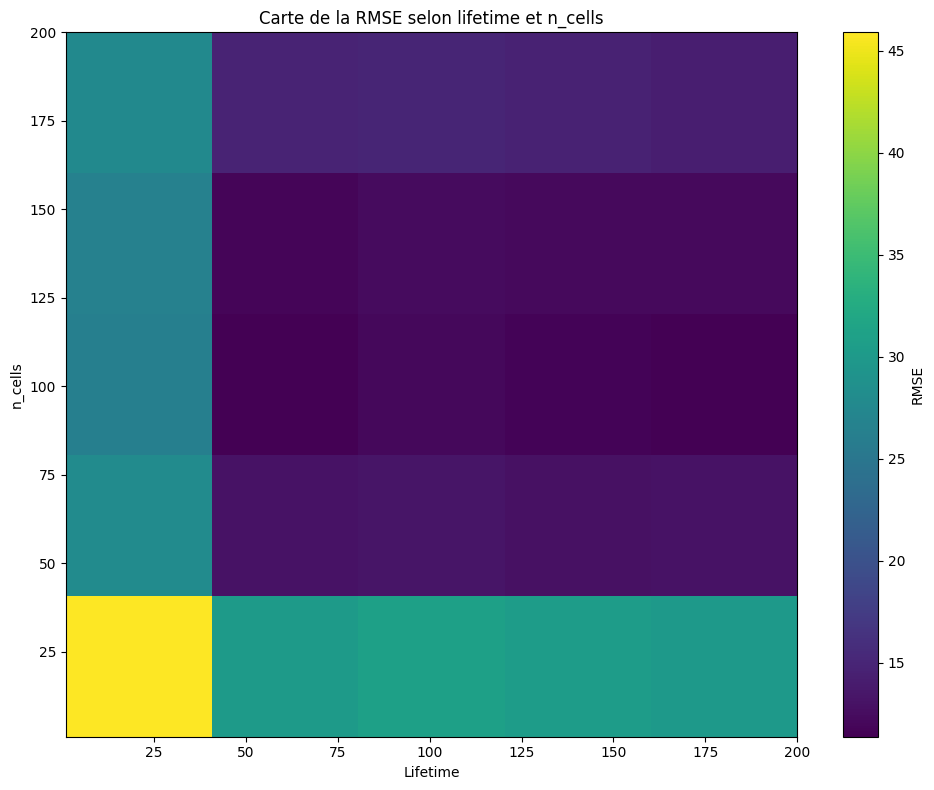

In [100]:
from tqdm import tqdm

# Définir les plages de lifetime et n_cells
lifetime_values = np.linspace(1, 200, 5)
n_cells_values = np.linspace(1, 200, 5)

# Initialiser la grille des RMSE
rmse_grid = np.zeros((len(n_cells_values), len(lifetime_values)))

# Boucle sur la grille
for i, n_cells in tqdm(enumerate(n_cells_values), total=len(n_cells_values)):
    for j, lifetime in enumerate(lifetime_values):
        model = MixedForest(n_estimators=100, lifetime=lifetime, lifetime_1=int(n_cells), random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_grid[i, j] = root_mean_squared_error(y_test, y_pred)

# Affichage de la heatmap
plt.figure(figsize=(10, 8))
plt.imshow(rmse_grid, extent=[lifetime_values.min(), lifetime_values.max(),
                              n_cells_values.min(), n_cells_values.max()],
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='RMSE')
plt.xlabel('Lifetime')
plt.ylabel('n_cells')
plt.title('Carte de la RMSE selon lifetime et n_cells')
plt.tight_layout()
plt.show()

In [101]:
from sklearn.model_selection import GridSearchCV

def cross_validation() : 
    grid = { 
        'n_estimators' : [1_000],
        'lifetime': [15, 20, 30, 40, 50]
        }

    extra_cv = GridSearchCV(
        estimator=SimpleMondrianForest(), 
        param_grid = grid,
        scoring = 'neg_root_mean_squared_error',
        cv = 5)

    extra_cv.fit(X_train, y_train)
    print(extra_cv.best_params_)

forest = SimpleMondrianForest(n_estimators=1000, lifetime= 0.1)
#extra = SimpleMondrianForest(
#    n_estimators = 1_000,
#    lifetime = extra_cv.best_params_['lifetime'])
#extra_fit = extra.fit(X_train, Y_train)

#extra_fit.score(X_test,Y_test)

#y_hat_extra = extra_fit.predict(X_test).reshape(-1)

#y_hat_extra

#plt.plot(y_hat_extra, label="Prediction")
#plt.plot(Y_test, label = "Vrai Y")
#plt.legend()



In [102]:
forest.fit(X_train, y_train)

In [103]:
y_hat = forest.predict(X_test)
print(y_test)
root_mean_squared_error(y_test, y_hat)


[np.float64(369.5752336419709), np.float64(508.26592466838923), np.float64(497.52506061732004), np.float64(344.58361935904514), np.float64(499.2140777689433), np.float64(442.2903055653492), np.float64(505.0580595401877), np.float64(493.4515556548751), np.float64(380.4799736403899), np.float64(427.6300560099948), np.float64(367.9833864998474), np.float64(418.61868744918047), np.float64(367.68696640631134), np.float64(419.52048493701733), np.float64(481.5998266100801), np.float64(426.5525209955404), np.float64(425.1345286285939), np.float64(493.33416199551596), np.float64(377.50668984061065), np.float64(514.5951767784703), np.float64(508.29942192923266), np.float64(464.9227457723058), np.float64(381.96970565983844), np.float64(472.1159971375951), np.float64(369.83259319523705), np.float64(427.3429997043588), np.float64(421.78128842812964), np.float64(474.69586500942546), np.float64(408.3598308306034), np.float64(366.01792356911494), np.float64(346.30682622136896), np.float64(445.41579289

49.85307227149333

In [104]:
cross_validation()

{'lifetime': 15, 'n_estimators': 1000}


In [105]:
def evaluation_with_n_growing():
    d = 10 # Dimension de l'espace des covariables
    liste_n = [10, 40, 150, 300, 600, 100, 500, 600, 800, 1_000, 2_000]
    liste_y = []
    liste_w = []
    liste_z = []
    liste_y_breiman = []
    liste_w_breiman = []
    liste_z_breiman = []
    s = d # niveau de sparsité
    for n in liste_n : 
        moyenne_y=[]
        moyenne_w=[]
        moyenne_z=[]
        moyenne_y_breiman=[]
        moyenne_w_breiman=[]
        moyenne_z_breiman=[]
        for _ in range(10) : 
            X = np.array([np.random.random(d) for _ in range(n)])
            eps = [np.random.normal(0,1) for _ in range(n)]
            Y = [10*sin(pi*X[i][0]*X[i][1])+20*(X[i][2]-5)**2+10*X[i][3]+5*X[i][4]+eps[i] for i in range(n)]
            Z = [20*exp(1/sqrt(s) * (sum([X[i][k] for k in range(s)])-0.5*s))+eps[i] for i in range(n)]
            W = [50*exp(-30*X[i][0]-5)+37+eps[i] for i in range(n)]

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

            model = MixedForest(n_estimators= 100, lifetime = 275, n_cells=100)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            moyenne_y.append(root_mean_squared_error(y_test, y_pred))

            rf = RandomForestRegressor(n_estimators=100, oob_score=True)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            moyenne_y_breiman.append(root_mean_squared_error(y_test, y_pred))
            
            
            X_train, X_test, z_train, z_test = train_test_split(X, Z, test_size=0.2, random_state=0)

            model = MixedForest(n_estimators= 100, lifetime = 275, n_cells=100)
            model.fit(X_train, z_train)
            z_pred = model.predict(X_test)
            moyenne_z.append(root_mean_squared_error(z_test, z_pred))

            rf = RandomForestRegressor(n_estimators=100, oob_score=True)
            rf.fit(X_train, z_train)
            z_pred = rf.predict(X_test)
            moyenne_z_breiman.append(root_mean_squared_error(z_test, z_pred))
            

            X_train, X_test, w_train, w_test = train_test_split(X, W, test_size=0.2, random_state=0)

            model = MixedForest(n_estimators= 100, lifetime = 275, n_cells=100)
            model.fit(X_train, w_train)
            w_pred = model.predict(X_test)
            moyenne_w.append(root_mean_squared_error(w_test, w_pred))

            rf = RandomForestRegressor(n_estimators=100, oob_score=True)
            rf.fit(X_train, w_train)
            w_pred = rf.predict(X_test)
            moyenne_w_breiman.append(root_mean_squared_error(w_test, w_pred))
            
            
        liste_y.append([n,sum(moyenne_y)/len(moyenne_y)])
        liste_w.append([n,sum(moyenne_w)/len(moyenne_w)])
        liste_z.append([n,sum(moyenne_z)/len(moyenne_z)])

        liste_y_breiman.append([n,sum(moyenne_y_breiman)/len(moyenne_y_breiman)])
        liste_w_breiman.append([n,sum(moyenne_w_breiman)/len(moyenne_w_breiman)])
        liste_z_breiman.append([n,sum(moyenne_z_breiman)/len(moyenne_z_breiman)])
    
    liste_y = np.array(liste_y)
    liste_w = np.array(liste_w)
    liste_z = np.array(liste_z)
    liste_y_breiman = np.array(liste_y_breiman)
    liste_w_breiman = np.array(liste_w_breiman)
    liste_z_breiman = np.array(liste_z_breiman)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(liste_z[:,0],liste_z[:,1],'o', label = "Fonction Z")
    ax.plot(liste_y[:,0],liste_y[:,1],'o', label = "Fonction Y")
    ax.plot(liste_w[:,0],liste_w[:,1],'o', label = "Fonction W")
    ax.plot(liste_z_breiman[:,0],liste_z_breiman[:,1],'o', label = "Fonction Z - Breiman")
    ax.plot(liste_y_breiman[:,0],liste_y_breiman[:,1],'o', label = "Fonction Y - Breiman")
    ax.plot(liste_w_breiman[:,0],liste_w_breiman[:,1],'o', label = "Fonction W - Breiman")
    plt.legend()    
    plt.show()

In [ ]:
#evaluation_with_n_growing()

In [106]:
def evaluation_with_n_growing_2(d):
    # Dimension de l'espace des covariables
    liste_n = [10, 150, 600, 500, 800, 1_000, 2_000, 4_000, 6_000]
    liste_y = []
    s = d # niveau de sparsité
    for n in liste_n : 
        moyenne_y=[]
        for _ in range(10) : 
            X = np.array([np.random.random(d) for _ in range(n)])
            eps = [np.random.normal(0,1) for _ in range(n)]
            Y = [10*sin(pi*X[i][0]*X[i][1])+20*(X[i][2]-5)**2+10*X[i][3]+5*X[i][4]+eps[i] for i in range(n)]

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

            model = MixedForest(n_estimators= 100, lifetime = 275, n_cells=100)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            moyenne_y.append(root_mean_squared_error(y_test, y_pred))
            
            
        liste_y.append([n,sum(moyenne_y)/len(moyenne_y)])
    
    liste_y = np.array(liste_y)
    compare = [u**(-2/(d+2)) for u in liste_n]

    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot()
    ax.plot(liste_y[:,0],liste_y[:,1],'o', label = "Fonction Y")
    ax.plot(liste_n,compare,'o', label = "Fonction Y")
    plt.legend()    
    plt.show()

In [ ]:
#evaluation_with_n_growing_2(10)

## Poubelle

In [ ]:
class SimpleSTITTree_discrete:
    def __init__(self, data, targets, directions, sommets, lifetime=float('inf'), depth=0):

        # IMPORTANT : On PART d'un polygone (on va dire un pavé). Si on part d'un convexe non polygonal, 
        # le calcul des taux ne marche plus (on n'a plus de sommets)

        self.data = np.array(data) # Les covariables X
        self.targets = np.array(targets) # La variable à prédire Y
        self.lifetime = lifetime  # budget de temps, paramètre lambda
        self.depth = depth # Indique à quel niveau de profondeur on se trouve
        self.n, self.d = self.data.shape # n taille de l'échantillon, d dimension des covariables
        self.bounds = np.column_stack((self.data.min(axis=0), self.data.max(axis=0))) # Bornes de la case
        self.split_dir = None # Direction dans laquelle on coupe (une des directions données au départ)
        self.split_val = None # Valeur de la coupe, une fois la dimension donnée
        self.left = self.right = None # Noeuds droits et gauche (qui sont eux-mêmes des arbres)
        self.tau = None # Temps aléatoire tiré selon une exponetielle à chaque itération
        self.mean = self.targets.mean() # Moyenne de Y dans la cellule
        self.var = self.targets.var() if self.n > 1 else 0.0 # Variance de Y dans la cellule
        self.directions = directions # Liste des directions (on va dans un premier temps supposer qu'on a une loi
        # uniforme sur cette liste de directions)
        self.sommets  = np.column_stack((self.data.min(axis=0), self.data.max(axis=0))) 
        # Liste des sommets du polygone qu'on est en train d'étudier 
        
        self._split()

    def _split(self):
        total_range = []
        for dir in self.directions : 
            high = max([np.dot(dir,sommet) for sommet in self.sommets])
            low = min([np.dot(dir, sommet) for sommet in self.sommets])
            prob = high - low
            total_range.append(prob)
        rate = total_range.sum()
        if rate <= 0 or self.lifetime <= 0 or self.n < 2:
            return
        probs = [x/rate for x in total_range]
            
        self.tau = random.expovariate(rate)
        if self.tau > self.lifetime:
            return

        self.split_dir = np.random.choice(self.directions, weights = probs)
        low, high = max([np.dot(dir,sommet) for sommet in self.sommets]), min([np.dot(dir, sommet) for sommet in self.sommets])
        self.split_val = random.uniform(low, high)

        proj_data = self.data.dot(self.split_dir)
        mask = proj_data <= self.split_val

        if mask.sum() == 0 or mask.sum() == self.n:
            return
        
        sommets_left = "blabla"

        sommets_right = "blabla"

        self.left = SimpleSTITTree(self.data[mask], self.targets[mask],
                                       self.directions, sommets_left,
                                        lifetime=self.lifetime - self.tau,
                                        depth=self.depth + 1)
        self.right = SimpleSTITTree(self.data[~mask], self.targets[~mask],
                                        self.directions, sommets_right,
                                         lifetime=self.lifetime - self.tau,
                                         depth=self.depth + 1)

    def predict_point(self, x, lifetime=None):
        if lifetime is None:
            lifetime = self.lifetime

        if self.split_dir is None or self.tau is None or self.tau > lifetime:
            return self.mean

        if x.dot(self.split_dir) <= self.split_val:
            return self.left.predict_point(x, lifetime - self.tau)
        else:
            return self.right.predict_point(x, lifetime - self.tau)

    def predict(self, X):
        return np.array([self.predict_point(x) for x in X])
    
    def draw(self, ax, bounds=None):
        """Dessine les frontières de l'arbre si données 2D."""
        if self.d != 2:
            raise ValueError("Le dessin n'est disponible que pour des données 2D.")
        if bounds is None:
            bounds = self.bounds.copy()

        if self.split_dim is not None:
            if self.split_dim == 0:
                ax.plot([self.split_val, self.split_val],
                        [bounds[1][0], bounds[1][1]], 'r-', linewidth=1)
                # Appel récursif
                if self.left:
                    self.left.draw(ax, np.array([[bounds[0][0], self.split_val], bounds[1]]))
                if self.right:
                    self.right.draw(ax, np.array([[self.split_val, bounds[0][1]], bounds[1]]))
            else:
                ax.plot([bounds[0][0], bounds[0][1]],
                        [self.split_val, self.split_val], 'b-', linewidth=1)
                if self.left:
                    self.left.draw(ax, np.array([bounds[0], [bounds[1][0], self.split_val]]))
                if self.right:
                    self.right.draw(ax, np.array([bounds[0], [self.split_val, bounds[1][1]]]))


SyntaxError: invalid syntax (2244210444.py, line 52)

In [ ]:
import argparse
import os
import sys
import time
import numpy as np

def afficher_erreur(message):
    sys.stderr.write(f"{message}\n")
    sys.exit(1)

def afficher_aide():
    parseur.print_help()

# Définition des arguments de la ligne de commande
parseur = argparse.ArgumentParser(description='Outil en ligne de commande tess19')
parseur.add_argument('--version', action='store_true', default=False, help='Afficher la version')
parseur.add_argument('--usage', action='store_true', default=False, help='Afficher l\'aide')
parseur.add_argument('--license', action='store_true', default=False, help='Afficher la licence')
parseur.add_argument('--Mondrian', action='store_true', default=False, help='Utiliser le mode Mondrian')
parseur.add_argument('--weights', default=False, help='Fichier de poids (facultatif)')
parseur.add_argument('--cuts', type=int, default=100, help='Nombre maximum de coupes')
parseur.add_argument('--tau', type=float, default=float('inf'), help='Budget de coupe (tau)')
parseur.add_argument('--alpha', type=float, default=1e-3, help='Paramètre alpha')
parseur.add_argument('--ntrees', type=int, default=100, help='Nombre d\'arbres (répétitions)')
parseur.add_argument('--particles', type=int, default=100, help='Nombre de particules')
parseur.add_argument('--seed', type=int, default=-1, help='Graine aléatoire')
parseur.add_argument('fname', nargs='?', help='Nom du fichier d\'entrée')

args, unknown = parseur.parse_known_args()


# Gérer les options simples

if args.license:
    if len(sys.argv) > 2:
        afficher_erreur('Erreur d\'argument (3)')
    else:
        afficher_licence()
        sys.exit(0)

if args.usage:
    if len(sys.argv) > 2:
        afficher_erreur('Erreur d\'argument (4)')
    else:
        afficher_aide()
        sys.exit(0)


# Détermination du type de coupe
type_coupe = 2 if args.Mondrian else 1

# Vérification de alpha
ALPHA = float(args.alpha)
if ALPHA < 0:
    afficher_erreur('L\'argument --alpha doit être positif')

# Affichage des informations générales
print("tess19 v1.0. Copyright (c) 2019. Shufei Ge et Lloyd T. Elliott.\n")
print(time.strftime("%a %b %d %X %Y"), end=' ')
print(os.getcwd(), "\n")

# Initialisation des paramètres
coupes_max = int(args.cuts)
tau = float(args.tau)
graine = args.seed
if graine == -1:
    graine = int((time.time() * 1000 + os.getpid()) % (2**31))
np.random.seed(graine)

type_echantillonnage = 1
taux_acceptation_min = 0.05
nb_particules = int(args.particles)
nb_arbres = int(args.ntrees)

# Chargement des poids si spécifié
if args.weights:
    if not os.path.exists(args.weights):
        afficher_erreur('Impossible d\'ouvrir le fichier de poids')
    poids_normaux = np.loadtxt(args.weights)
    poids_normaux = poids_normaux / np.sum(poids_normaux)
else:
    poids_normaux = None

import numpy as np

def normaliser_matrice(V):
    """Normalise chaque colonne de la matrice V entre 0 et 1."""
    min_col = np.min(V, axis=0)
    max_col = np.max(V, axis=0)
    return (V - min_col) / (max_col - min_col)

def cut_plane_standard(V, V_ID, V_label, sample_type, cut_type, accept_rate_min, dist_max=None, w_normal=None):
    """
    Fonction qui réalise une coupe aléatoire sur un nuage de points V.

    V : matrice numpy (n x d)
    V_ID : identifiants (non utilisé dans cette fonction mais conservé pour compatibilité)
    V_label : étiquettes des points (np.array ou liste)
    sample_type : entier (1 ou autre)
    cut_type : entier (1 ou 2)
    accept_rate_min : float, taux d'acceptation minimal
    dist_max : float ou None, distance max utilisée pour l'échantillonnage
    w_normal : poids pour normaliser la direction (vecteur numpy)
    
    Retourne un dict avec plusieurs informations sur la coupe.
    """
    d = V.shape[1]
    P_u = None
    mu = None
    len_projection = None
    normal_v = None
    sample_cut_count = 1
    V_left_ID = None
    V_right_ID = None

    if w_normal is None:
        w_normal = np.ones(d) / d

    # Identifier les indices où V_label n'est pas NaN
    label_mask = ~np.isnan(V_label)
    
    if np.sum(label_mask) > 0:
        # Uniques lignes des points étiquetés
        V_unique = np.unique(V[label_mask], axis=0)
        d1 = V_unique.shape[0]
        
        if dist_max is None:
            if d1 == 1:
                dist_max = 0
            else:
                # Matrice des distances euclidiennes entre points uniques
                from scipy.spatial.distance import pdist
                dist_max = np.max(pdist(V_unique))
        
        # Condition pour sauter la coupe si tous les labels sont identiques ou dist_max=0
        unique_labels = np.unique(V_label[label_mask])
        skip_index = (len(unique_labels) == 1) or (dist_max == 0)
    else:
        skip_index = True  # Tous les sommets sont non étiquetés => skip

    if not skip_index:
        run_index = True
        if sample_type == 1:
            if cut_type == 1:
                while run_index:
                    # Génération d'un vecteur normal "normal.v"
                    normal_v = np.random.normal(scale=0.1, size=d)
                    normal_v = w_normal * normal_v
                    normal_v /= np.linalg.norm(normal_v)

                    # Projection des points sur la direction normal_v
                    t_scale = (V @ normal_v) / np.sum(normal_v**2)
                    t_scale_train = t_scale[label_mask]
                    t_scale_ends = [np.min(t_scale_train), np.max(t_scale_train)]

                    # Points aux extrémités de la projection
                    V_projection_ends = np.vstack([t_scale_ends[0]*normal_v, t_scale_ends[1]*normal_v])
                    len_projection = (t_scale_ends[1] - t_scale_ends[0]) * np.linalg.norm(normal_v)

                    mu = np.random.uniform(0, dist_max)
                    mu /= len_projection
                    if mu < 1:
                        t_scale_mu = (1 - mu) * t_scale_ends[0] + mu * t_scale_ends[1]
                        # Vérifier si la coupe divise bien les points étiquetés
                        if np.any(t_scale_train <= t_scale_mu) and np.any(t_scale_train > t_scale_mu):
                            run_index = False
                            P_u = (1 - mu) * V_projection_ends[0, :] + mu * V_projection_ends[1, :]
                            V_left_ID = np.where(t_scale <= t_scale_mu)[0]
                            V_right_ID = np.where(t_scale > t_scale_mu)[0]
                    else:
                        sample_cut_count += 1
                        run_index = (1 / sample_cut_count) > accept_rate_min
                        skip_index = not run_index
            else:
                while run_index:
                    # Vecteur normal tiré selon la loi multinomiale selon w_normal
                    normal_v = np.random.multinomial(1, w_normal).astype(float)

                    t_scale = (V @ normal_v) / np.sum(normal_v**2)
                    t_scale_train = t_scale[label_mask]
                    t_scale_ends = [np.min(t_scale_train), np.max(t_scale_train)]

                    V_projection_ends = np.vstack([t_scale_ends[0]*normal_v, t_scale_ends[1]*normal_v])
                    len_projection = (t_scale_ends[1] - t_scale_ends[0]) * np.linalg.norm(normal_v)

                    mu = np.random.uniform(0, dist_max)
                    mu /= len_projection

                    if mu < 1:
                        t_scale_mu = (1 - mu) * t_scale_ends[0] + mu * t_scale_ends[1]
                        if np.any(t_scale_train <= t_scale_mu) and np.any(t_scale_train > t_scale_mu):
                            run_index = False
                            P_u = (1 - mu) * V_projection_ends[0, :] + mu * V_projection_ends[1, :]
                            V_left_ID = np.where(t_scale <= t_scale_mu)[0]
                            V_right_ID = np.where(t_scale > t_scale_mu)[0]
                    else:
                        sample_cut_count += 1
                        run_index = (1 / sample_cut_count) > accept_rate_min
                        skip_index = not run_index
        else:
            run_index = True
            while run_index:
                if cut_type == 1:
                    normal_v = np.random.normal(scale=0.1, size=d)
                    normal_v = w_normal * normal_v
                    normal_v /= np.linalg.norm(normal_v)
                else:
                    normal_v = np.random.multinomial(1, w_normal).astype(float)

                t_scale = (V @ normal_v) / np.sum(normal_v**2)
                t_scale_train = t_scale[label_mask]
                t_scale_ends = [np.min(t_scale_train), np.max(t_scale_train)]
                V_projection_ends = np.vstack([t_scale_ends[0]*normal_v, t_scale_ends[1]*normal_v])
                len_projection = (t_scale_ends[1] - t_scale_ends[0]) * np.linalg.norm(normal_v)

                mu = np.random.uniform(0, 1)
                t_scale_mu = (1 - mu) * t_scale_ends[0] + mu * t_scale_ends[1]

                if np.any(t_scale_train <= t_scale_mu) and np.any(t_scale_train > t_scale_mu):
                    run_index = False
                    P_u = (1 - mu) * V_projection_ends[0, :] + mu * V_projection_ends[1, :]
                    V_left_ID = np.where(t_scale <= t_scale_mu)[0]
                    V_right_ID = np.where(t_scale > t_scale_mu)[0]
                else:
                    sample_cut_count += 1
                    run_index = sample_cut

import numpy as np

def generative_process(partition, V_all, V_label, tau, group_level, group_len,
                       sample_type, cut_type, accept_rate_min, w_normal, dist_all):
    """
    Processus génératif pour affiner une partition par coupes successives.

    Args:
        partition (dict): dictionnaire avec clés 'Polytopes' (liste de dict) et 'tau' (liste)
        V_all (np.array): matrice des données (n x d)
        V_label (np.array): vecteur des labels
        tau (float): budget tau maximal
        group_level (list): niveaux des groupes
        group_len (int): nombre de groupes
        sample_type, cut_type, accept_rate_min, w_normal : paramètres divers
        dist_all (np.array): matrice des distances (n x n)

    Retourne:
        dict avec partition mise à jour, indicateur coupe, infos de coupe, et skip flag
    """
    l = len(partition['Polytopes'])
    d = V_all.shape[1]
    tau_v = partition['tau']
    result = (0, 0, 0)  # inutilisé dans R, peut-être à ignorer
    Cut = None
    cut_idx = 0
    skip_all = 0

    # Conversion en factor R, ici on garde group_level tel quel
    group_level2 = np.array(group_level)

    if tau_v[-1] >= tau:
        skip_all = 1
    else:
        Lambdas = np.array([poly['Lambda'] for poly in partition['Polytopes']])

        # Conditions de sélection des polytopes candidats :
        cond1 = Lambdas > 0
        
        # cond2: obs ne sont pas du même groupe (similaire au R)
        # En R, c'est un peu obscur => on teste si les labels ne sont pas tous identiques
        cond2 = []
        for poly in partition['Polytopes']:
            counts = np.bincount(poly['CountByGroup'])
            cond2.append(np.sum(counts > 1) > 1)
        cond2 = np.array(cond2)

        if np.sum(cond1 & cond2) == 0:
            skip_all = 1
        else:
            sample_space = np.where(cond1 & cond2)[0]
            if len(sample_space) == 1:
                j = sample_space[0]
            else:
                probs = Lambdas[sample_space] / np.sum(Lambdas[sample_space])
                j = np.random.choice(sample_space, p=probs)

            V_temp_ID = partition['Polytopes'][j]['V.ID']
            V_temp = V_all[V_temp_ID, :]
            V_temp_label = V_label[V_temp_ID]
            dist_max = partition['Polytopes'][j]['dist_max']

            Cut = cut_plane_standard(V_temp, V_temp_ID, V_temp_label,
                                     sample_type, cut_type, accept_rate_min,
                                     dist_max, w_normal)

            if Cut['skip_index'] != 1:
                index_left = Cut['V_left_ID']
                index_right = Cut['V_right_ID']

                if len(index_left) == 1:
                    V_temp_left = V_temp[index_left, :].reshape(1, -1)
                else:
                    V_temp_left = V_temp[index_left, :]

                if len(index_right) == 1:
                    V_temp_right = V_temp[index_right, :].reshape(1, -1)
                else:
                    V_temp_right = V_temp[index_right, :]

                V_temp_ID_left = V_temp_ID[index_left]
                V_temp_ID_right = V_temp_ID[index_right]

                cut_idx = 1
                l += 1

                # Calcul des distances max dans chaque sous-polytope
                dist_max_left = np.max(dist_all[np.ix_(V_temp_ID_left, V_temp_ID_left)])
                dist_max_right = np.max(dist_all[np.ix_(V_temp_ID_right, V_temp_ID_right)])

                Lambda_left = dist_max_left / 2
                Lambda_right = dist_max_right / 2

                # Calcul nombre par groupe
                count_by_group_left = np.array([np.sum(V_label[V_temp_ID_left] == g) for g in group_level2])
                count_by_group_right = np.array([np.sum(V_label[V_temp_ID_right] == g) for g in group_level2])

                # Mise à jour des polytopes
                partition['Polytopes'][j] = {'V.ID': V_temp_ID_left,
                                            'Lambda': Lambda_left,
                                            'CountByGroup': count_by_group_left,
                                            'dist_max': dist_max_left}
                partition['Polytopes'].append({'V.ID': V_temp_ID_right,
                                              'Lambda': Lambda_right,
                                              'CountByGroup': count_by_group_right,
                                              'dist_max': dist_max_right})

                Lambdas = np.array([poly['Lambda'] for poly in partition['Polytopes']])
                tau_v_plus1 = np.random.exponential(scale=1/np.sum(Lambdas)) + tau_v[-1]
                tau_v = np.append(tau_v, tau_v_plus1)
                partition['tau'] = tau_v

    return {'partition': partition,
            'cut_indx': cut_idx,
            'Cut': Cut,
            'skip_all': skip_all}


def partition_initial(group_level, group_len, V_all, V_label, l_max, tau,
                      sample_type, cut_type, accept_rate_min):
    """
    Initialisation d’une partition.

    Args:
        group_level, group_len : info des groupes
        V_all : données
        V_label : labels
        l_max, tau : paramètres
        sample_type, cut_type, accept_rate_min : paramètres
    Returns:
        dict contenant 'Partition.Inital' (partition initiale) et matrice des distances
    """
    group_level2 = np.array(group_level)
    n = len(V_label)
    V_temp_ID = np.arange(n)
    V_temp = V_all[V_temp_ID, :]
    d = V_all.shape[1]

    from scipy.spatial.distance import pdist, squareform
    dist_all = squareform(pdist(V_all))

    count_by_group = np.array([np.sum(V_label == g) for g in group_level2])

    dist_max = np.max(dist_all)
    Polytopes = [{'V.ID': V_temp_ID,
                  'Lambda': dist_max / 2,
                  'CountByGroup': count_by_group,
                  'dist_max': dist_max}]

    Partition_Initial = {'Polytopes': Polytopes,
                         'tau': [np.random.exponential(scale=1 / Polytopes[0]['Lambda'])]}

    return {'Partition.Initial': Partition_Initial, 'dist_all': dist_all}


def getmode(v):
    """
    Mode d’un vecteur (valeur la plus fréquente).
    """
    vals, counts = np.unique(v, return_counts=True)
    return vals[np.argmax(counts)]


tess19 v1.0. Copyright (c) 2019. Shufei Ge et Lloyd T. Elliott.

Fri Jul 11 15:17:14 2025 c:\Users\capot\OneDrive - GENES\Documents\ENSAE 1A\Projet et orientation\Stage 3A\Travail\mondrianforest-master\src 



In [ ]:
import numpy as np
from scipy.spatial import HalfspaceIntersection, ConvexHull
from scipy.optimize import linprog

def random_unit_vector(d):
    vec = np.random.normal(size=d)
    return vec / np.linalg.norm(vec)

def compute_c_interval(W_halfspaces, n):
    # W_halfspaces : list of inequalities (A_i, b_i) s.t. A_i x + b_i <= 0
    # On veut min/max de <n, x> s.t. x in W
    # => Problèmes de PL pour trouver min et max c
    
    A = np.array([hs[0] for hs in W_halfspaces])
    b = np.array([hs[1] for hs in W_halfspaces])
    
    # Minimize <n, x>
    res_min = linprog(c=n, A_ub=A, b_ub=-b, method='highs')
    # Maximize <n, x> <=> minimize -<n, x>
    res_max = linprog(c=-n, A_ub=A, b_ub=-b, method='highs')
    
    if res_min.success and res_max.success:
        return res_min.fun, -res_max.fun
    else:
        raise ValueError("PL problème non résolu, polytope peut être vide")

def cut_polytope(W_halfspaces, n, c):
    # Découpe polytope défini par demi-espaces W_halfspaces en deux parties par hyperplan <n,x>=c
    # Retourne deux listes de demi-espaces (H-représentation)
    pos_halfspaces = W_halfspaces + [( -n, c )]  # < -n, x > + c <= 0 <=> < n, x> >= c
    neg_halfspaces = W_halfspaces + [( n, -c )]  # < n, x > + (-c) <= 0
    
    return pos_halfspaces, neg_halfspaces

def stit_tessellation_general(a, W_halfspaces, d):
    T = [(0, W_halfspaces)]
    R = []
    
    while T:
        tau, cell = T.pop(0)
        
        # Approximer l'intensité (exemple : surface de la frontière)
        # Ici, on simplifie en prenant une constante, à adapter selon contexte
        intensity = 1.0  
        tau_j = np.random.exponential(scale=1/intensity)
        
        if tau + tau_j <= a:
            n = random_unit_vector(d)
            c_min, c_max = compute_c_interval(cell, n)
            c = np.random.uniform(c_min, c_max)
            pos, neg = cut_polytope(cell, n, c)
            T.append((tau + tau_j, pos))
            T.append((tau + tau_j, neg))
        else:
            R.append(cell)
    return R


In [ ]:
import numpy as np

def is_point_in_polytope(point, halfspaces):
    # halfspaces : list of (A, b) tuples, ineq: A x + b <= 0
    for A, b in halfspaces:
        if np.dot(A, point) + b > 1e-12:  # tolérance
            return False
    return True

def assign_points_to_cells_general(points, cells):
    # points : np.array shape (n_points, d)
    # cells : list of halfspaces (H-rep)
    assignments = []
    for pt in points:
        found = False
        for i, cell in enumerate(cells):
            if is_point_in_polytope(pt, cell):
                assignments.append(i)
                found = True
                break
        if not found:
            assignments.append(None)
    return assignments


In [ ]:
import numpy as np
from itertools import product

def largest_enclosing_cube_vertices(data):
    data = np.array(data)
    d = data.shape[1]

    mins = np.min(data, axis=0)
    maxs = np.max(data, axis=0)

    # Taille du côté du cube = max étendue sur une dimension
    side_length = np.max(maxs - mins)

    # Centre du cube (centre du bounding box)
    center = (mins + maxs) / 2

    # Sommets du cube : toutes combinaisons de -side_length/2 ou +side_length/2 pour chaque coordonnée
    offsets = np.array(list(product([-0.5, 0.5], repeat=d))) * side_length

    vertices = center + offsets

    return vertices



def hyperplane_intersects_polytope(vertices, n, x, u):
    shifted = vertices - (x + u * n)
    dots = shifted @ n
    all_pos = np.all(dots > 1e-12)
    all_neg = np.all(dots < -1e-12)
    return not (all_pos or all_neg)

def sample_hyperplane_intersecting_polytope(vertices, x, r, d, max_iter=10000):
    for _ in range(max_iter):
        n = sample_unit_vector(d)
        u = np.random.uniform(0, r)
        if hyperplane_intersects_polytope(vertices, n, x, u):
            return n, u
    raise RuntimeError("Rejet sampling échoué")

def sample_unit_vector(d) :
    v = np.random.normal(size=d)
    return v / np.linalg.norm(v)

def point_in_halfspace(p, n, u, x):
    return np.dot(p - (x + u * n), n) <= 0  # <= à gauche, > à droite

def split_polytope(vertices, n, u, x, d):
    """
    Découpe le polytope représenté par ses sommets selon l'hyperplan <n, P - (x + u n)> = 0
    
    Retourne deux listes de sommets pour les sous-polytopes à gauche et à droite.
    """
    vertices = np.array(vertices)
    shifted = vertices - (x + u * n)
    dots = shifted @ n

    left_points = vertices[dots < -1e-12]
    right_points = vertices[dots > 1e-12]
    on_plane = vertices[np.abs(dots) <= 1e-12]

    left_points = np.vstack([left_points, on_plane]) if len(on_plane) > 0 else left_points
    right_points = np.vstack([right_points, on_plane]) if len(on_plane) > 0 else right_points

    # On enlève les doublons, ça peut aider qhull
    left_points = np.unique(left_points, axis=0)
    right_points = np.unique(right_points, axis=0)

    # Vérifier la taille des ensembles par rapport à la dimension
    if len(left_points) < d + 1 or len(right_points) < d + 1:
        return vertices, vertices

    try:
        #print("J'essaye !")
        #left_hull = ConvexHull(left_points)
        #print("C'est bon à gauche !")
        #right_hull = ConvexHull(right_points)
        #print("C'est bon à droite !")
        return left_points[left_hull.vertices], right_points[right_hull.vertices]
    except QhullError:
        return vertices, vertices




    
def STIT_sample(a_vertices, a, d, data, targets):
    """
    Algorithme STIT avec rejection sampling d'hyperplans
    
    a_vertices : sommets initiaux du polytope a
    a : temps maximal
    d : dimension
    """
    from collections import deque
    from scipy.spatial.distance import cdist
    
    # Centre du polytope initial
    x = np.mean(a_vertices, axis=0)
    # Plus grande distance entre deux sommets du polytope
    r = np.max(np.linalg.norm(a_vertices - x, axis=1)) 
    
    T = deque() # Queue à doube-entrée
    T.append((0, a_vertices, data, targets))
    R = []
    
    while T:
        print("Ca boucle !")
        tau, W_prime, data_prime, targets_prime = T.popleft()
        # Mise à jour centre et rayon pour W_prime
        x = np.mean(W_prime, axis=0)
        r = np.max(np.linalg.norm(W_prime - x, axis=1))
        
        # Tirage temps exponentiel avec paramètre [W_prime]
        radius = r # Rayon de la plus petite boule contenant les données
        # Mais qu'on simplifie comme la plus petite distance entre les points
        tau_j = np.random.exponential(2 * radius)
        
        if tau + tau_j <= a:
            # Tirage hyperplan coupant W_prime
            print("Tirage d'un hypeprlan")
            n, u = sample_hyperplane_intersecting_polytope(W_prime, x, r, d)
            
            # Découpage
            print("On coupe le polytope")
            W_plus, W_minus = split_polytope(W_prime, n, u, x, d)

            # Séparation des données selon leur position
            data_plus = []
            data_minus = []
            targets_plus = []
            targets_minus = []

            for i, p in enumerate(data_prime):
                print("On range les data")
                if point_in_halfspace(p, n, u, x):  # côté "moins"
                    data_minus.append(p)
                    targets_minus.append(targets_prime[i])
                else:
                    data_plus.append(p)
                    targets_plus.append(targets_prime[i])
            
            # Ajout des nouveaux sous-polytopes avec temps mis à jour
            T.append((tau + tau_j, W_plus, np.array(data_plus), np.array(targets_plus)))
            T.append((tau + tau_j, W_minus, np.array(data_minus), np.array(targets_minus)))
        else:
            R.append((W_prime, data_prime, targets_prime))

    
    return R

from scipy.spatial import Delaunay

def is_in_convex_hull(x, hull_points, tol=1e-12):
    hull_points = np.unique(hull_points, axis=0)  # enlever doublons
    d = hull_points.shape[1]
    if len(hull_points) < d + 1:
        # Pas assez de points pour définir un polytope plein-dim
        return False
    try:
        delaunay = Delaunay(hull_points)
        simplex = delaunay.find_simplex(x)
        if simplex >= 0:
            print("Youpi")
            return True
        # Sinon, test manuel avec une tolérance (facultatif)
        print("Hourra")
        return np.min(np.linalg.norm(hull_points - x, axis=1)) < tol
    except QhullError:
        print("Raté")
        return False


In [ ]:
import numpy as np
from scipy.spatial import ConvexHull, QhullError
import statistics

class SimpleSTITTree:
    def __init__(self, data, targets, lifetime=float('inf')):
        self.data = np.array(data)
        self.targets = np.array(targets)
        self.lifetime = lifetime
        self.n, self.d = self.data.shape
        self.hyperplanes = []
        self.positions = None
        self.vertices = ConvexHull(data).vertices
        self.partition = self._partition()

    def _partition(self) :
        return STIT_sample(self.vertices, self.lifetime, self.d, self.data, self.targets)
    
    def predict_point(self, x) : 
        for W, data, targets in self.partition:
            if is_in_convex_hull(x, W):
                print("True")
                return statistics.mean(targets)
        return 0

    def predict(self, X):
        return np.array([self.predict_point(x) for x in X])

In [ ]:
# Evaluation sur des données de diabète - Cas de l'arbre de Mondrian

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tree = SimpleSTITTree(X_train, y_train, lifetime = 1)
#print(tree.n_cuts, tree.radius)
y_pred = tree.predict(X_test)
y_pred_2 = np.array([np.mean(y_train)]*len(y_test)) # Constante égale à la moyenne
print("RMSE de l'arbre STIT :", root_mean_squared_error(y_test, y_pred))
print("RMSE par rapport à la moyenne simple :", root_mean_squared_error(y_test, y_pred_2)) # Erreur par rapport au prédicteur constant

Recopie du code R

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform

# ----- Utils -----

def get_mode(v):
    # Retourne le mode d'une liste (ie la valeur la plus fréquente)
    values, counts = np.unique(v[~np.isnan(v)], return_counts=True)
    return values[np.argmax(counts)]

# ----- Partition initiale -----

def partition_initial(group_level, V_all, V_label):
    n = len(V_label) # Taille des données
    V_temp_ID = np.arange(n)

    # Donne la matrice des distances entre les X
    dist_all = squareform(pdist(V_all))

    counts = np.array([np.sum(V_label == g) for g in group_level])
    countbygroup = counts

    dist_max = np.max(dist_all) # Plus grande distance entre deux X
    polytope = {
        'V.ID': V_temp_ID,
        'Lambda': dist_max / 2,
        'CountByGroup': countbygroup,
        'dist.max': dist_max
    }

    Polytopes = [polytope]

    Partition_Initial = {
        'Polytopes': Polytopes,
        'tau': [np.random.exponential(1 / polytope['Lambda'])]
    }

    return {
        'Partition_Initial': Partition_Initial,
        'dist_all': dist_all
    }

# ----- Fonction de coupe -----

def cut_plane_standard(V, V_label, sample_type, cut_type, accept_rate_min, dist_max=None, w_normal=None):
    d = V.shape[1] # Dimension des données de prédiction
    P_u = np.full(d, np.nan) 
    mu = np.nan
    len_projection = np.nan
    normal_v = np.full(d, np.nan)
    sample_cut_count = 1
    V_left_ID, V_right_ID = [], []

    # Cas où on ne demande pas de choisir des poids sur les directions (option par défaut)
    if w_normal is None:
        w_normal = np.full(d, 1/d)

    # Si on a plus d'une étiquette non vide
    if np.sum(~np.isnan(V_label)) > 0:
        V_unique = np.unique(V[~np.isnan(V_label)], axis=0) # On identifie les x qui ont une prédiction associé, en enlevant les doublons
        d1 = V_unique.shape[0] # On identifie le nombre de ces x sans doublon
        # On cherche à voir si l'ensemble des x est réduit à un singleton
        if dist_max is None:
            dist_max = 0 if d1 == 1 else np.max(pdist(V_unique))
        
        #skip the cut if all obs are from the same group(pausing condition)
        # or if labled vertices are same
        skip_index = (len(np.unique(V_label[~np.isnan(V_label)])) == 1) or (dist_max == 0)
    else:
        skip_index = True # skip if all vertices are unlabled
    
    # Si la coupe a bien lieu
    if not skip_index:
        run_index = True
        while run_index:
            if cut_type == 1:
                normal_v = np.random.normal(0, 1, d) * w_normal
                normal_v /= np.linalg.norm(normal_v)
            else:
                normal_v = np.zeros(d)
                choice = np.random.choice(d, p=w_normal)
                normal_v[choice] = 1

            t_scale = V @ normal_v / np.sum(normal_v ** 2)
            t_scale_train = t_scale[~np.isnan(V_label)]
            t_scale_ends = [np.min(t_scale_train), np.max(t_scale_train)]
            len_projection = (t_scale_ends[1] - t_scale_ends[0]) * np.linalg.norm(normal_v)

            if sample_type == 1 and dist_max is not None:
                mu = np.random.uniform(0, dist_max) / len_projection
            else:
                mu = np.random.uniform(0, 1)

            if mu < 1:
                t_scale_mu = (1 - mu) * t_scale_ends[0] + mu * t_scale_ends[1]
                if np.any(t_scale_train <= t_scale_mu) and np.any(t_scale_train > t_scale_mu):
                    run_index = False
                    P_u = (1 - mu) * t_scale_ends[0] * normal_v + mu * t_scale_ends[1] * normal_v
                    V_left_ID = np.where(t_scale <= t_scale_mu)[0]
                    V_right_ID = np.where(t_scale > t_scale_mu)[0]
            else:
                sample_cut_count += 1
                run_index = (1 / sample_cut_count > accept_rate_min)
                skip_index = not run_index

    return {
        'N_vec': normal_v,
        'Pu': P_u,
        'Len_projection': len_projection,
        'dist_max': dist_max,
        'sample_cut_count': sample_cut_count,
        'skip_index': int(skip_index),
        'V_left_ID': V_left_ID,
        'V_right_ID': V_right_ID
    }

# ----- Processus Génératif -----

def generative_process(partition, V_all, V_label, tau, group_level, group_len,
                       sample_type, cut_type, accept_rate_min, w_normal, dist_all):
    l = len(partition['Polytopes'])
    tau_v = partition['tau']
    Cut = {}
    cut_idx = 0
    skip_all = 0
    group_level2 = np.array(group_level)

    if tau_v[-1] >= tau:
        skip_all = 1
    else:
        Lambdas = np.array([p['Lambda'] for p in partition['Polytopes']])
        cond1 = Lambdas > 0
        cond2 = [len(np.unique(V_label[p['V.ID']][~np.isnan(V_label[p['V.ID']])])) > 1 for p in partition['Polytopes']]
        cond2 = np.array(cond2)
        cond12 = np.sum(cond1 & cond2)

        if cond12 == 0:
            skip_all = 1
        else:
            sample_space = np.where(cond1 & cond2)[0]
            probs = Lambdas[sample_space]
            probs /= probs.sum()
            j = np.random.choice(sample_space, p=probs)

            V_temp_ID = partition['Polytopes'][j]['V.ID']
            V_temp = V_all[V_temp_ID]
            V_temp_label = V_label[V_temp_ID]
            dist_max = partition['Polytopes'][j]['dist.max']

            Cut = cut_plane_standard(V_temp, V_temp_label, sample_type, cut_type,
                                     accept_rate_min, dist_max, w_normal)

            if Cut['skip_index'] != 1:
                idx_left = Cut['V_left_ID']
                idx_right = Cut['V_right_ID']
                V_ID_left = V_temp_ID[idx_left]
                V_ID_right = V_temp_ID[idx_right]

                dist_left = np.max(dist_all[np.ix_(V_ID_left, V_ID_left)])
                dist_right = np.max(dist_all[np.ix_(V_ID_right, V_ID_right)])
                Lambda_left = dist_left / 2
                Lambda_right = dist_right / 2

                def count_group(ids):
                    counts = np.zeros(group_len)
                    for g in range(group_len):
                        counts[g] = np.sum(V_label[ids] == group_level[g])
                    return counts

                partition['Polytopes'][j] = {
                    'V.ID': V_ID_left,
                    'Lambda': Lambda_left,
                    'CountByGroup': count_group(V_ID_left),
                    'dist.max': dist_left
                }

                partition['Polytopes'].append({
                    'V.ID': V_ID_right,
                    'Lambda': Lambda_right,
                    'CountByGroup': count_group(V_ID_right),
                    'dist.max': dist_right
                })

                Lambdas = np.array([p['Lambda'] for p in partition['Polytopes']])
                tau_next = np.random.exponential(1 / Lambdas.sum()) + tau_v[-1]
                tau_v.append(tau_next)
                partition['tau'] = tau_v
                cut_idx = 1

    return {
        'partition': partition,
        'cut_indx': cut_idx,
        'Cut': Cut,
        'skip_all': skip_all
    }

# ----- MAIN SCRIPT -----

# Exemple d'utilisation basique (avec données simulées) :


#np.random.seed(42)
n_samples = 100
d_features = 5
V_all = np.random.rand(n_samples, d_features)
V_label = np.random.choice([0, 1, 2], size=n_samples).astype(float)
group_level = np.unique(V_label)
group_len = len(group_level)

tau = 100.0
sample_type = 1
cut_type = 2
accept_rate_min = 0.01
w_normal = np.ones(d_features) / d_features
dicos = partition_initial(group_level, V_all, V_label)
partition = dicos['Partition_Initial']
dist_all = dicos['dist_all']


result = generative_process(partition, V_all, V_label, tau, group_level, group_len, sample_type, cut_type, accept_rate_min, w_normal, dist_all)

print("Cut performed:", result['cut_indx'])
if result['cut_indx'] == 1:
    print("Cut info:", result['Cut'])



Cut performed: 1
Cut info: {'N_vec': array([0., 0., 1., 0., 0.]), 'Pu': array([0.        , 0.        , 0.80150496, 0.        , 0.        ]), 'Len_projection': np.float64(0.9895744522721895), 'dist_max': np.float64(1.7461660256945695), 'sample_cut_count': 1, 'skip_index': 0, 'V_left_ID': array([ 0,  2,  3,  4,  5,  7,  9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 28, 31, 33, 34, 36, 37, 38, 40, 41, 42, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 59, 60, 62, 64, 65, 66,
       68, 69, 71, 72, 73, 74, 75, 76, 77, 79, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99]), 'V_right_ID': array([ 1,  6,  8, 13, 16, 27, 29, 30, 32, 35, 39, 43, 57, 58, 61, 63, 67,
       70, 78, 80, 96])}


In [ ]:
def simulate_stit_partition(V_all, V_label, group_level, max_time, w_normal=None):
    # Initialisation
    d = V_all.shape[1]
    n = V_all.shape[0]
    
    # Partition initiale
    dicos = partition_initial(group_level, V_all, V_label)
    partition = dicos['Partition_Initial']
    dist_all = dicos['dist_all']
    
    # Initialiser temps d’attente pour chaque polytope
    Lambdas = np.array([p['Lambda'] for p in partition['Polytopes']])
    tau = np.random.exponential(1 / Lambdas)  # vecteur des temps d'attente
    times = tau  # temps de "fin" de chaque polytope
    
    current_time = 0.0
    
    while current_time < max_time and len(partition['Polytopes']) > 0:
        # Trouver polytope avec temps d'attente minimal
        idx = np.argmin(times)
        next_time = times[idx]
        
        if next_time > max_time:
            break
        
        current_time = next_time
        
        # Extraire polytope à découper
        poly = partition['Polytopes'][idx]
        V_temp_ID = poly['V.ID']
        V_temp = V_all[V_temp_ID]
        V_temp_label = V_label[V_temp_ID]
        dist_max = poly['dist.max']
        
        # Effectuer coupe
        cut_res = cut_plane_standard(V_temp, V_temp_ID, V_temp_label, 
                                     sample_type=1, cut_type=1, 
                                     accept_rate_min=0.01, dist_max=dist_max, w_normal=w_normal)
        
        if cut_res['skip_index'] == 1:
            # Si pas de coupe possible, on retire ce polytope (ou on le marque inactif)
            # Ici on supprime ou on met un temps infini
            times[idx] = np.inf
            continue
        
        # Mettre à jour partition : remplacer polytope idx par les 2 nouveaux
        idx_left = cut_res['V_left_ID']
        idx_right = cut_res['V_right_ID']
        V_ID_left = V_temp_ID[idx_left]
        V_ID_right = V_temp_ID[idx_right]
        
        dist_left = np.max(dist_all[np.ix_(V_ID_left, V_ID_left)]) if len(V_ID_left) > 0 else 0
        dist_right = np.max(dist_all[np.ix_(V_ID_right, V_ID_right)]) if len(V_ID_right) > 0 else 0
        Lambda_left = dist_left / 2
        Lambda_right = dist_right / 2
        
        def count_group(ids):
            counts = np.zeros(len(group_level))
            for g in range(len(group_level)):
                counts[g] = np.sum(V_label[ids] == group_level[g])
            return counts
        
        # Remplacer polytope coupé
        partition['Polytopes'][idx] = {
            'V.ID': V_ID_left,
            'Lambda': Lambda_left,
            'CountByGroup': count_group(V_ID_left),
            'dist.max': dist_left
        }
        # Ajouter polytope droit
        partition['Polytopes'].append({
            'V.ID': V_ID_right,
            'Lambda': Lambda_right,
            'CountByGroup': count_group(V_ID_right),
            'dist.max': dist_right
        })
        
        # Mettre à jour temps d’attente
        # Le polytope coupé reçoit un nouveau temps d’attente
        times[idx] = current_time + np.random.exponential(1 / Lambda_left) if Lambda_left > 0 else np.inf
        times = np.append(times, current_time + np.random.exponential(1 / Lambda_right) if Lambda_right > 0 else np.inf)
    
    return partition
